# **GPS Connectivity Analysis - Philippines**
**Machine Learning Model for Employment Location Prediction Based on Geographic and Connectivity Metrics**

Analysis of GPS-fixed tiles and their connectivity metrics across Philippine municipalities, integrated with employment distribution data from LFS (Labor Force Survey) to predict employment locations.

## **Table of Contents**

- **Imports & Setup:** All required imports and environment checks.
- **Section 1 — Data Loading:** Load GPS tiles and administrative boundaries.
- **Section 2 — EDA & Preprocessing:** Visualizations and descriptive statistics.
- **Section 3 — Data Integration:** PSGC & LFS cleaning and merging (population & employment).
- **Section 4 — Feature Engineering:** Build feature-engineered dataset and exports.
- **Section 5 — Modeling:** Indices, clustering and ML outputs.
- **Section 6 — Visualizations:** Plots, cluster visualizations and maps.
- **Section 7 — Summary & Map:** Executive summary and interactive map output.

# **Section 1: Data Loading**
Import all required libraries and load data sources from **geographic shapefiles (gps_fixed_tiles.shp)** and **CSV files (PSGC-3Q-2025-Publication-Datafile.csv & LFS-PUF-October-2024.csv)**.

## 1.1 *Load GPS Tiles and Geographic Boundaries*

In [20]:
# ============================================================================
# IMPORT REQUIRED LIBRARIES FOR DATA PROCESSING, VISUALIZATION, AND ML
# ============================================================================

import geopandas as gpd                     # Geospatial data handling
import matplotlib.pyplot as plt             # Data visualization
import textwrap                             # Text formatting for long titles
import pandas as pd                         # Data manipulation and analysis
import numpy as np                          # Numerical computing
from IPython.display import display, HTML   # Interactive display in notebooks
from geopy.distance import geodesic         # Calculate geographic distance

In [21]:
# Detect fuzzywuzzy availability early (used by matching cells)
try:
    from fuzzywuzzy import fuzz, process
    HAS_FUZZY = True
except Exception:
    HAS_FUZZY = False

In [22]:
# Load GPS fixed tiles
gadm_path = "gps_fixed_tiles.shp"
gdf = gpd.read_file(gadm_path)

In [23]:
# Load Philippines administrative boundaries
ph = gpd.read_file('gadm41_PHL_2.json')

print(f"GPS tiles loaded: {len(gdf)} records")
print(f"Philippines regions loaded: {len(ph)} records")

GPS tiles loaded: 6561086 records
Philippines regions loaded: 1647 records


## 1.2 *Filter and Spatial Join - Philippines Region Only*

In [8]:
# Spatial join: keep only tiles intersecting Philippines
gdf_ph = gpd.sjoin(gdf, ph, how='inner', predicate='intersects')
print(f"Original tiles: {len(gdf):,}")
print(f"Philippines tiles: {len(gdf_ph):,}")

Original tiles: 6,561,086
Philippines tiles: 122,135


## 1.3 *Data Cleaning - Select Essential Columns*

In [9]:
# Keep only essential columns: connectivity metrics, location, and geometry
columns_to_keep = ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'NAME_1', 'NAME_2', 'geometry']
gdf_ph_clean = gdf_ph[columns_to_keep].copy()

print(f"Cleaned data shape: {gdf_ph_clean.shape}")
print(f"Columns: {list(gdf_ph_clean.columns)}")

gdf_ph_clean.head(10)

Cleaned data shape: (122135, 9)
Columns: ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'NAME_1', 'NAME_2', 'geometry']


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,NAME_1,NAME_2,geometry
5536815,1323011032213303,6893,3166,93,5,1,Batanes,Itbayat,"POLYGON ((121.79993 20.73043, 121.80542 20.730..."
5536816,1323011032300102,61871,19376,58,22,4,Batanes,Itbayat,"POLYGON ((121.83838 20.79207, 121.84387 20.792..."
5536817,1323011032300103,126903,22322,51,9,1,Batanes,Itbayat,"POLYGON ((121.84387 20.79207, 121.84937 20.792..."
5536818,1323011032300120,27709,14701,67,3,3,Batanes,Itbayat,"POLYGON ((121.83838 20.78693, 121.84387 20.786..."
5536819,1323011210311031,99101,13362,45,31,10,Batanes,Basco,"POLYGON ((121.96472 20.4579, 121.97021 20.4579..."
5536820,1323011210311033,72703,17360,45,223,49,Batanes,Basco,"POLYGON ((121.96472 20.45275, 121.97021 20.452..."
5536821,1323011210311122,58675,15824,37,96,47,Batanes,Basco,"POLYGON ((121.97021 20.45275, 121.97571 20.452..."
5536822,1323011210311123,41427,16849,45,9,4,Batanes,Basco,"POLYGON ((121.97571 20.45275, 121.9812 20.4527..."
5536823,1323011210311130,16680,5494,40,1,1,Batanes,Basco,"POLYGON ((121.9812 20.4579, 121.98669 20.4579,..."
5536824,1323011210311211,60786,16608,48,59,28,Batanes,Basco,"POLYGON ((121.96472 20.4476, 121.97021 20.4476..."


# **Section 2: Exploratory Data Analysis (EDA) and Preprocessing**

## 2.1 *Visualize GPS Coverage*

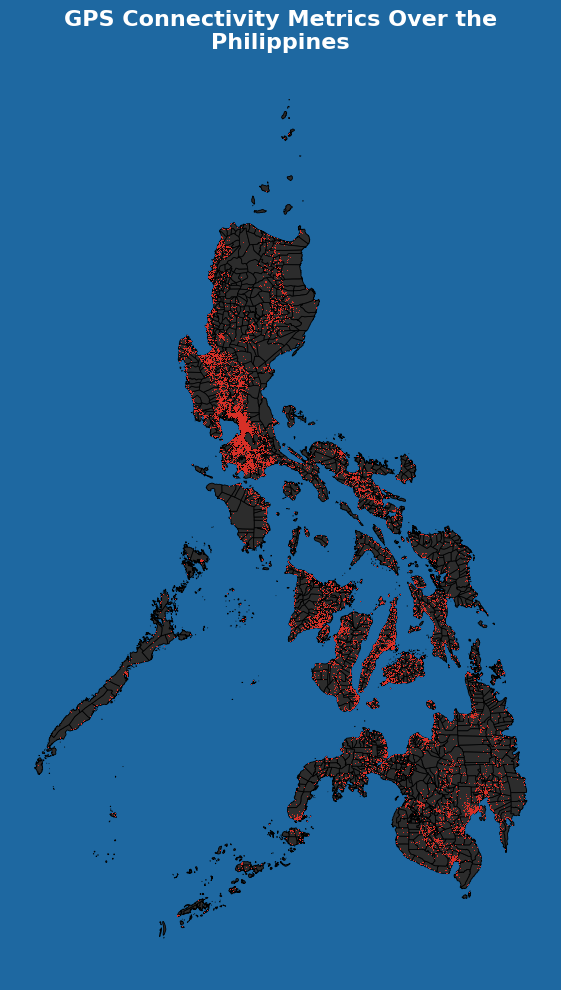

In [10]:
fig, ax = plt.subplots(figsize=(12, 10), facecolor="#1E68A1")

# Plot Philippines boundary and GPS tiles
# Keep the Philippines boundary slightly darker and tiles in red
ph.plot(ax=ax, color="#2c2c2c", edgecolor="#000000", linewidth=0.6)
gdf_ph_clean.plot(ax=ax, facecolor='#d73027', edgecolor='none', alpha=1)

# Remove axis lines/ticks (no border)
ax.set_axis_off()

# Title and layout
long_title = "GPS Connectivity Metrics Over the Philippines"
ax.set_title("\n".join(textwrap.wrap(long_title, width=40)), fontsize=16, fontweight='bold', color='white')
ax.set_aspect('equal')
plt.tight_layout()

# Save output
plt.savefig('Exploratory Data Analysis (EDA)/gps_fixed_tiles_over_philippines_presentable.png', dpi=500, bbox_inches='tight', pad_inches=0.1, facecolor=fig.get_facecolor())
plt.show()

## 2.2 *Descriptive Statistics and Distribution Analysis*

### 2.2.1 *Descriptive Statistics*

**Summary statistics for all connectivity metrics across the Philippines.**

In [11]:
# Create a non-spatial dataframe for statistics
df_stats = pd.DataFrame(gdf_ph_clean.drop(columns=['geometry']))

# Descriptive statistics
print("=" * 80)
print("DESCRIPTIVE STATISTICS - Connectivity Metrics Across Philippines")
print("=" * 80)
print(df_stats[['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices']].describe().round(2))
print("\n")

# Interpretation
print("KEY INSIGHTS:")
print(f"• Download Speed (avg_d_kbps): Mean={df_stats['avg_d_kbps'].mean():.0f} kbps, "
      f"Median={df_stats['avg_d_kbps'].median():.0f} kbps")
print(f"  → Most tiles have download speeds between {df_stats['avg_d_kbps'].quantile(0.25):.0f} - {df_stats['avg_d_kbps'].quantile(0.75):.0f} kbps")
print(f"\n• Upload Speed (avg_u_kbps): Mean={df_stats['avg_u_kbps'].mean():.0f} kbps, "
      f"Median={df_stats['avg_u_kbps'].median():.0f} kbps")
print(f"  → Upload speeds are typically lower than download speeds (asymmetric networks)")
print(f"\n• Latency (avg_lat_ms): Mean={df_stats['avg_lat_ms'].mean():.1f} ms, "
      f"Median={df_stats['avg_lat_ms'].median():.1f} ms")
print(f"  → Indicates network responsiveness; lower is better for real-time applications")
print(f"\n• Test Coverage: Mean={df_stats['tests'].mean():.1f} tests per tile, "
      f"Mean={df_stats['devices'].mean():.1f} devices per tile")
print(f"  → Data reliability varies; some tiles have more measurements than others")

DESCRIPTIVE STATISTICS - Connectivity Metrics Across Philippines
       avg_d_kbps  avg_u_kbps  avg_lat_ms      tests    devices
count   122135.00   122135.00   122135.00  122135.00  122135.00
mean     83599.18    81395.32       22.78      33.98       9.64
std      74090.26    77685.92       35.26     113.76      31.50
min         10.00        1.00        1.00       1.00       1.00
25%      24039.50    17578.50        8.00       2.00       1.00
50%      63718.00    57564.00       13.00       5.00       2.00
75%     126657.50   127095.00       27.00      19.00       5.00
max     830607.00   952872.00     1110.00    7751.00    1397.00


KEY INSIGHTS:
• Download Speed (avg_d_kbps): Mean=83599 kbps, Median=63718 kbps
  → Most tiles have download speeds between 24040 - 126658 kbps

• Upload Speed (avg_u_kbps): Mean=81395 kbps, Median=57564 kbps
  → Upload speeds are typically lower than download speeds (asymmetric networks)

• Latency (avg_lat_ms): Mean=22.8 ms, Median=13.0 ms
  → Indicates

### 2.2.2 *Distribution of Connectivity Metrics*

**Visualize the distribution of download speed, upload speed, and latency to identify patterns and outliers.**

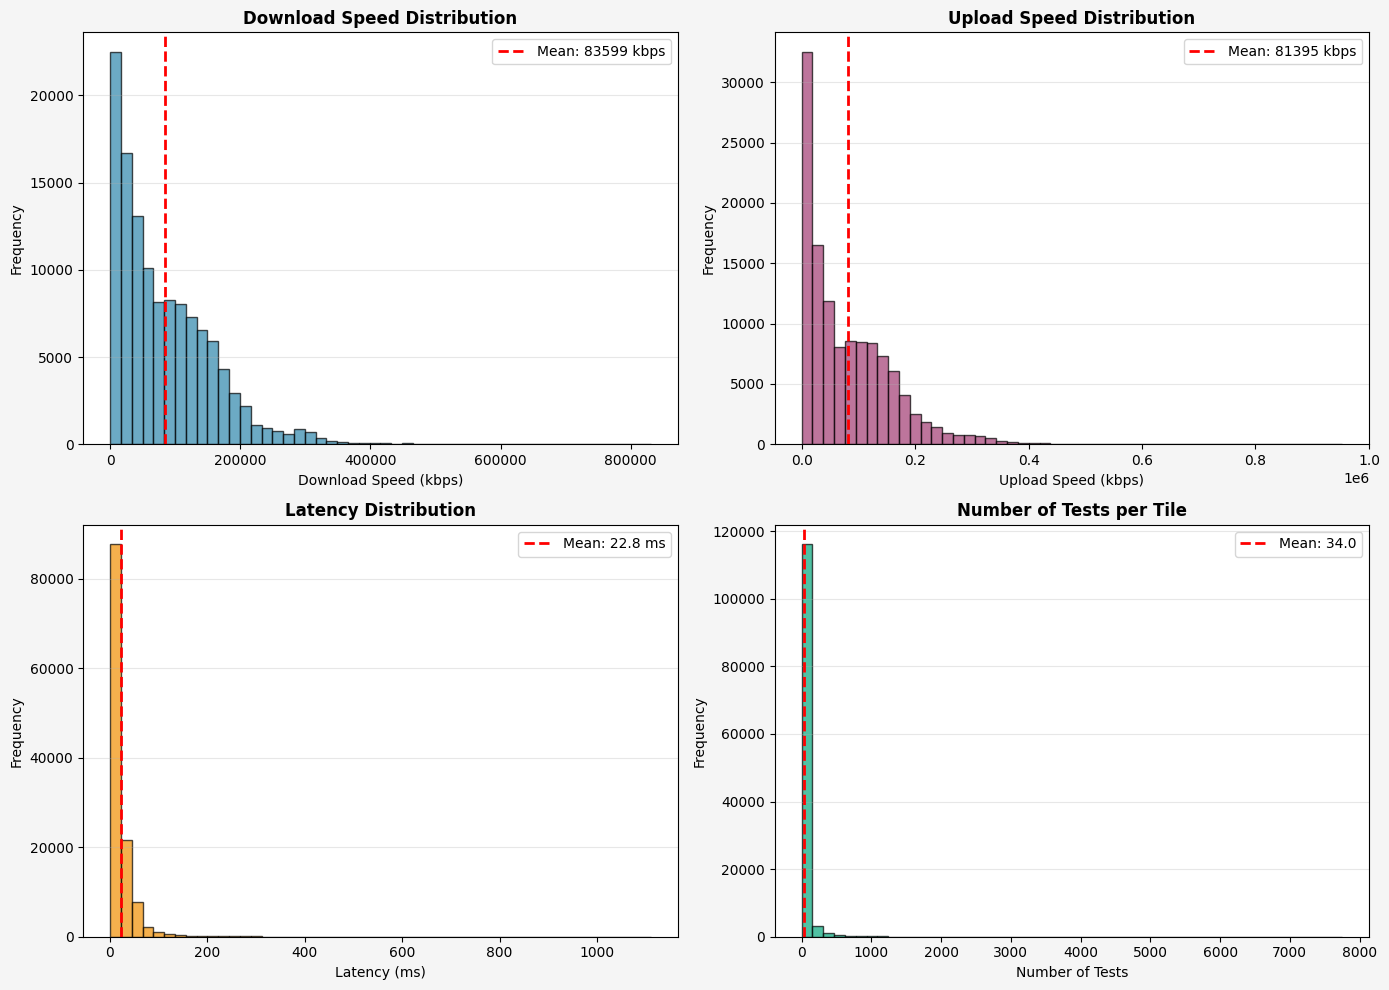

INTERPRETATION:
• Download speeds show right-skewed distribution → most tiles have lower speeds, few high-speed areas
• Upload speeds similarly skewed → consistent pattern of slower uploads
• Latency centered around mean → relatively stable network responsiveness
• Test frequency varies → some areas have been tested more frequently than others


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='#f5f5f5')

# Download Speed Distribution
axes[0, 0].hist(df_stats['avg_d_kbps'], bins=50, color='#2E86AB', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Download Speed Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Download Speed (kbps)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_stats['avg_d_kbps'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_stats["avg_d_kbps"].mean():.0f} kbps')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Upload Speed Distribution
axes[0, 1].hist(df_stats['avg_u_kbps'], bins=50, color='#A23B72', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Upload Speed Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Upload Speed (kbps)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_stats['avg_u_kbps'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_stats["avg_u_kbps"].mean():.0f} kbps')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Latency Distribution
axes[1, 0].hist(df_stats['avg_lat_ms'], bins=50, color='#F18F01', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Latency Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Latency (ms)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_stats['avg_lat_ms'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_stats["avg_lat_ms"].mean():.1f} ms')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Tests per Tile
axes[1, 1].hist(df_stats['tests'], bins=50, color='#06A77D', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Number of Tests per Tile', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Tests')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df_stats['tests'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_stats["tests"].mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# Save output
plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/distribution_of_connectivity_metrics.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

print("INTERPRETATION:")
print("• Download speeds show right-skewed distribution → most tiles have lower speeds, few high-speed areas")
print("• Upload speeds similarly skewed → consistent pattern of slower uploads")
print("• Latency centered around mean → relatively stable network responsiveness")
print("• Test frequency varies → some areas have been tested more frequently than others")


### 2.2.3 *Connectivity Performance by Province*

**Top and bottom performing provinces based on average download speed.**

In [13]:
# Group by province (NAME_1) for performance analysis
province_stats = df_stats.groupby('NAME_1').agg({
    'avg_d_kbps': ['mean', 'count'],
    'avg_u_kbps': 'mean',
    'avg_lat_ms': 'mean'
}).round(2)

province_stats.columns = ['Download Speed (kbps)', 'Tile Count', 'Upload Speed (kbps)', 'Latency (ms)']
province_stats = province_stats.sort_values('Download Speed (kbps)', ascending=False)

print("TOP 10 FASTEST PROVINCES")
display(province_stats.head(10).style.background_gradient(subset=['Download Speed (kbps)'], cmap='Greens'))

print("\nBOTTOM 10 SLOWEST PROVINCES")
display(province_stats.tail(10).style.background_gradient(subset=['Download Speed (kbps)'], cmap='Reds'))

TOP 10 FASTEST PROVINCES


,Download Speed (kbps),Tile Count,Upload Speed (kbps),Latency (ms)
NAME_1,,,,
MetropolitanManila,159572.460000,2079,149497.930000,6.660000
Cavite,136547.780000,2846,135592.240000,12.420000
Laguna,126715.980000,2755,126660.140000,10.930000
Bulacan,123540.120000,3173,119538.170000,11.000000
IlocosNorte,121605.850000,1674,122591.640000,15.510000
Batangas,119527.570000,4742,123733.700000,12.790000
Rizal,118679.930000,1563,116334.540000,10.440000
LaUnion,114534.660000,1320,116316.810000,7.050000
Benguet,114209.850000,828,108919.310000,18.420000



BOTTOM 10 SLOWEST PROVINCES


,Download Speed (kbps),Tile Count,Upload Speed (kbps),Latency (ms)
NAME_1,,,,
CompostelaValley,44142.900000,1286,40642.360000,33.310000
SultanKudarat,43861.850000,1192,37125.050000,64.470000
SouthernLeyte,41707.340000,838,37016.970000,29.430000
NorthernSamar,37623.350000,712,30193.680000,46.340000
Tawi-Tawi,36007.660000,148,10923.160000,57.810000
Biliran,32115.850000,372,20051.790000,37.350000
Sulu,27636.190000,254,10343.650000,53.130000
Basilan,25588.990000,365,8647.460000,57.650000
DinagatIslands,25208.560000,163,9562.660000,55.780000


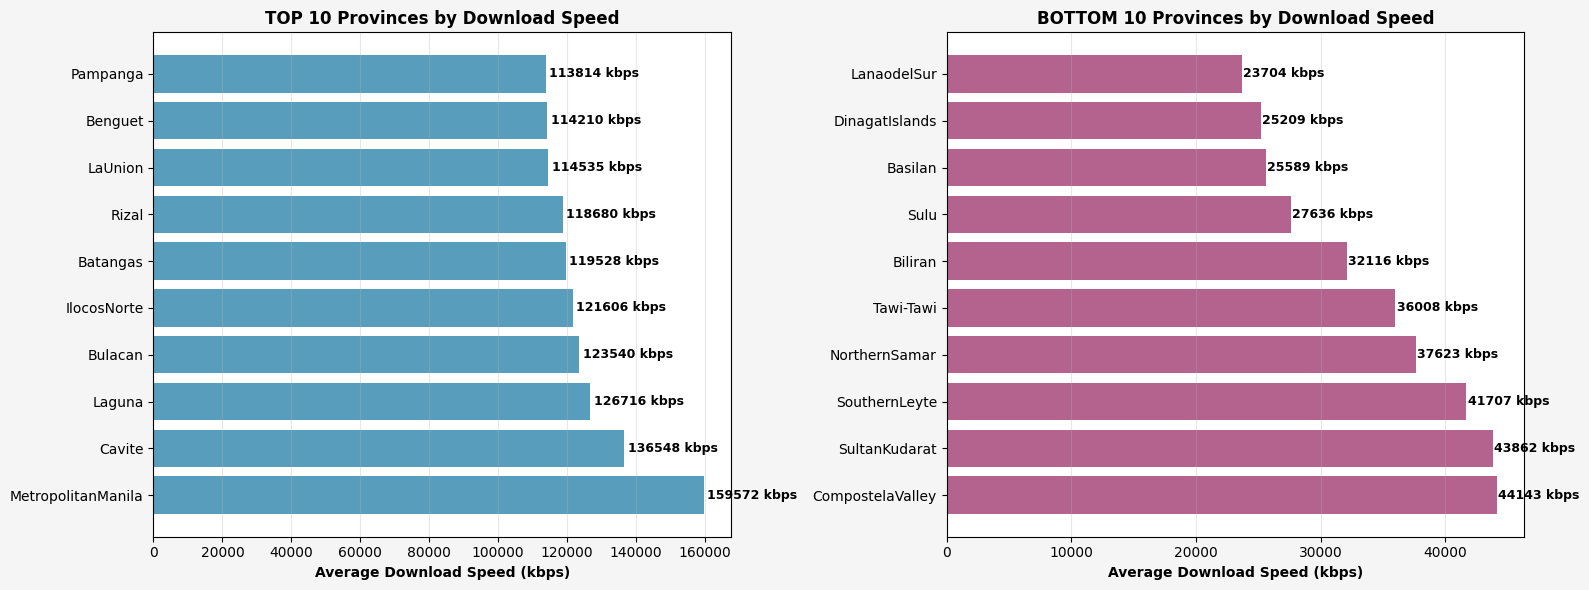

In [14]:
# Visualization: Top 10 provinces
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='#f5f5f5')

top_provinces = province_stats.head(10)
bottom_provinces = province_stats.tail(10)

# Top provinces
axes[0].barh(range(len(top_provinces)), top_provinces['Download Speed (kbps)'], color='#2E86AB', alpha=0.8)
axes[0].set_yticks(range(len(top_provinces)))
axes[0].set_yticklabels(top_provinces.index)
axes[0].set_xlabel('Average Download Speed (kbps)', fontweight='bold')
axes[0].set_title('TOP 10 Provinces by Download Speed', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_provinces['Download Speed (kbps)']):
    axes[0].text(v + 1000, i, f'{v:.0f} kbps', va='center', fontsize=9, fontweight='bold')

# Bottom provinces
axes[1].barh(range(len(bottom_provinces)), bottom_provinces['Download Speed (kbps)'], color='#A23B72', alpha=0.8)
axes[1].set_yticks(range(len(bottom_provinces)))
axes[1].set_yticklabels(bottom_provinces.index)
axes[1].set_xlabel('Average Download Speed (kbps)', fontweight='bold')
axes[1].set_title('BOTTOM 10 Provinces by Download Speed', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(bottom_provinces['Download Speed (kbps)']):
    axes[1].text(v + 100, i, f'{v:.0f} kbps', va='center', fontsize=9, fontweight='bold')

# Save output
plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/connectivity_performance_by_province.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

fastest = province_stats.index[0]
fastest_speed = province_stats['Download Speed (kbps)'].iloc[0]
slowest = province_stats.index[-1]
slowest_speed = province_stats['Download Speed (kbps)'].iloc[-1]
speed_range = fastest_speed - slowest_speed
multiplier = fastest_speed / slowest_speed

divide_html = f"""
<div style="line-height: 2.2; font-size: 11pt; padding: 15px; border-radius: 8px; border-left: 10px solid #d73027;">
<p><b style="color: #2E86AB; font-size: 12pt;">Fastest Province:</b> <b style="color: #06A77D;">{fastest}</b><br>
<span style="color: #666; margin-left: 20px;">Average Speed: {fastest_speed:,.0f} kbps ({fastest_speed/1000:.1f} Mbps)</span></p>

<p><b style="color: #d73027; font-size: 12pt;">Slowest Province:</b> <b style="color: #A23B72;">{slowest}</b><br>
<span style="color: #666; margin-left: 20px;">Average Speed: {slowest_speed:,.0f} kbps ({slowest_speed/1000:.1f} Mbps)</span></p>

<p><b style="font-size: 12pt; color: #F18F01;">Digital Gap:</b><br>
<span style="color: #d73027; font-weight: bold; margin-left: 20px;">{speed_range:,.0f} kbps difference</span> ({multiplier:.1f}x faster in fastest province)<br>
<span style="color: #666; margin-left: 20px;">Indicates <b>significant regional inequality</b> - urban provinces dramatically outpace rural areas</span></p>
</div>
"""
display(HTML(divide_html))

### *2.2.4 Download vs Upload Speed Relationship*

**Scatter plot showing the relationship between download and upload speeds across all tiles.**

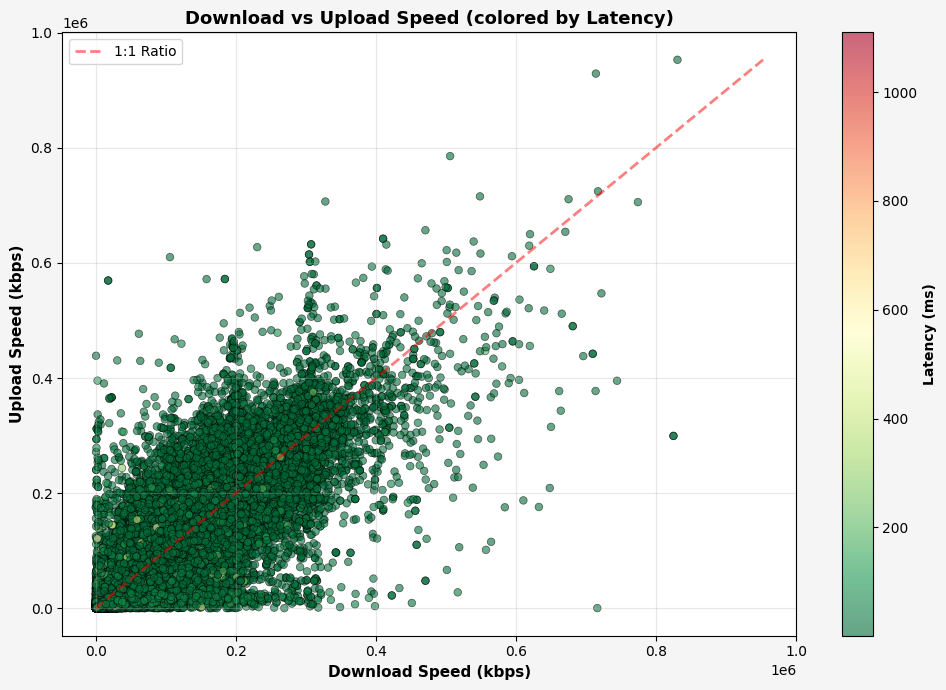

CORRELATION ANALYSIS:
• Download-Upload Speed Correlation: 0.886
• High correlation (0.886) → areas with fast download also have fast upload
• Download/Upload Ratio: 1.03:1
• Most connections are asymmetric (downloads >> uploads), typical for consumer broadband


In [15]:
fig, ax = plt.subplots(figsize=(10, 7), facecolor='#f5f5f5')

# Create scatter plot colored by latency
scatter = ax.scatter(df_stats['avg_d_kbps'], df_stats['avg_u_kbps'], 
                     c=df_stats['avg_lat_ms'], cmap='RdYlGn_r', 
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Download Speed (kbps)', fontweight='bold', fontsize=11)
ax.set_ylabel('Upload Speed (kbps)', fontweight='bold', fontsize=11)
ax.set_title('Download vs Upload Speed (colored by Latency)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add diagonal line for reference (1:1 ratio)
max_speed = max(df_stats['avg_d_kbps'].max(), df_stats['avg_u_kbps'].max())
ax.plot([0, max_speed], [0, max_speed], 'r--', linewidth=2, label='1:1 Ratio', alpha=0.5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Latency (ms)', fontweight='bold')
ax.legend()

# Save output
plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/download_vs_Upload_Speed_Relationship.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Calculate correlation
correlation = df_stats['avg_d_kbps'].corr(df_stats['avg_u_kbps'])
print(f"CORRELATION ANALYSIS:")
print(f"• Download-Upload Speed Correlation: {correlation:.3f}")
print(f"• High correlation ({correlation:.3f}) → areas with fast download also have fast upload")
print(f"• Download/Upload Ratio: {(df_stats['avg_d_kbps'].mean() / df_stats['avg_u_kbps'].mean()):.2f}:1")
print(f"• Most connections are asymmetric (downloads >> uploads), typical for consumer broadband")

### 2.2.5 *Data Coverage Analysis*

**Understanding the reliability and comprehensiveness of the data by test frequency and device count.**

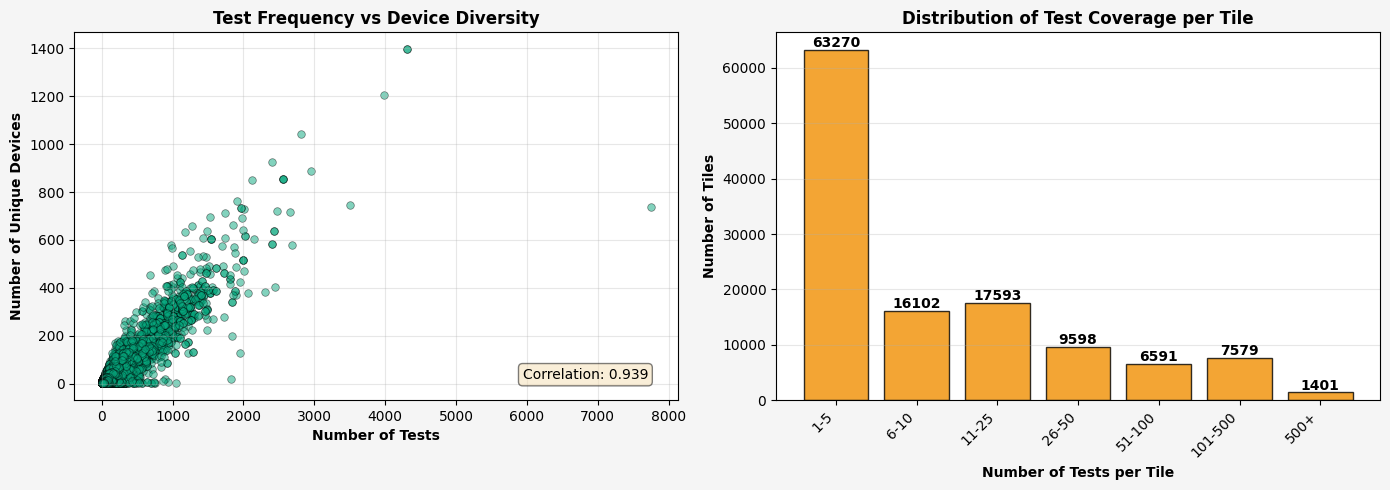

DATA COVERAGE INSIGHTS:
• Total tiles with measurements: 122,135
• Tiles with < 5 tests: 57,923 (47.4%)
• Tiles with ≥ 10 tests: 45,123 (36.9%)
• Tiles with ≥ 50 tests: 15,827 (13.0%)
• Tests-Devices Correlation: 0.939 → high correlation means reliable measurement samples
• Many tiles have sparse testing → results may be less reliable in low-test areas


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor='#f5f5f5')

# Tests vs Devices scatter
axes[0].scatter(df_stats['tests'], df_stats['devices'], alpha=0.5, s=30, color='#06A77D', edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Number of Tests', fontweight='bold')
axes[0].set_ylabel('Number of Unique Devices', fontweight='bold')
axes[0].set_title('Test Frequency vs Device Diversity', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add correlation coefficient
tests_devices_corr = df_stats['tests'].corr(df_stats['devices'])
axes[0].text(0.95, 0.05, f'Correlation: {tests_devices_corr:.3f}', 
             transform=axes[0].transAxes, fontsize=10, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Distribution of coverage metrics
coverage_bins = [0, 5, 10, 25, 50, 100, 500, 5000]
coverage_labels = ['1-5', '6-10', '11-25', '26-50', '51-100', '101-500', '500+']
df_stats['test_category'] = pd.cut(df_stats['tests'], bins=coverage_bins, labels=coverage_labels)

coverage_count = df_stats['test_category'].value_counts().sort_index()
axes[1].bar(range(len(coverage_count)), coverage_count.values, color='#F18F01', alpha=0.8, edgecolor='black')
axes[1].set_xticks(range(len(coverage_count)))
axes[1].set_xticklabels(coverage_count.index, rotation=45, ha='right')
axes[1].set_xlabel('Number of Tests per Tile', fontweight='bold')
axes[1].set_ylabel('Number of Tiles', fontweight='bold')
axes[1].set_title('Distribution of Test Coverage per Tile', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(coverage_count.values):
    axes[1].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Save output
plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/data_coverage_analysis.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

print("DATA COVERAGE INSIGHTS:")
print(f"• Total tiles with measurements: {len(df_stats):,}")
print(f"• Tiles with < 5 tests: {len(df_stats[df_stats['tests'] < 5]):,} ({len(df_stats[df_stats['tests'] < 5])/len(df_stats)*100:.1f}%)")
print(f"• Tiles with ≥ 10 tests: {len(df_stats[df_stats['tests'] >= 10]):,} ({len(df_stats[df_stats['tests'] >= 10])/len(df_stats)*100:.1f}%)")
print(f"• Tiles with ≥ 50 tests: {len(df_stats[df_stats['tests'] >= 50]):,} ({len(df_stats[df_stats['tests'] >= 50])/len(df_stats)*100:.1f}%)")
print(f"• Tests-Devices Correlation: {tests_devices_corr:.3f} → high correlation means reliable measurement samples")
print(f"• Many tiles have sparse testing → results may be less reliable in low-test areas")

### 2.2.6 *Speed Categories and Connectivity Quality*

**Classify tiles into speed categories (Slow, Medium, Fast, Very Fast) and analyze distribution.**

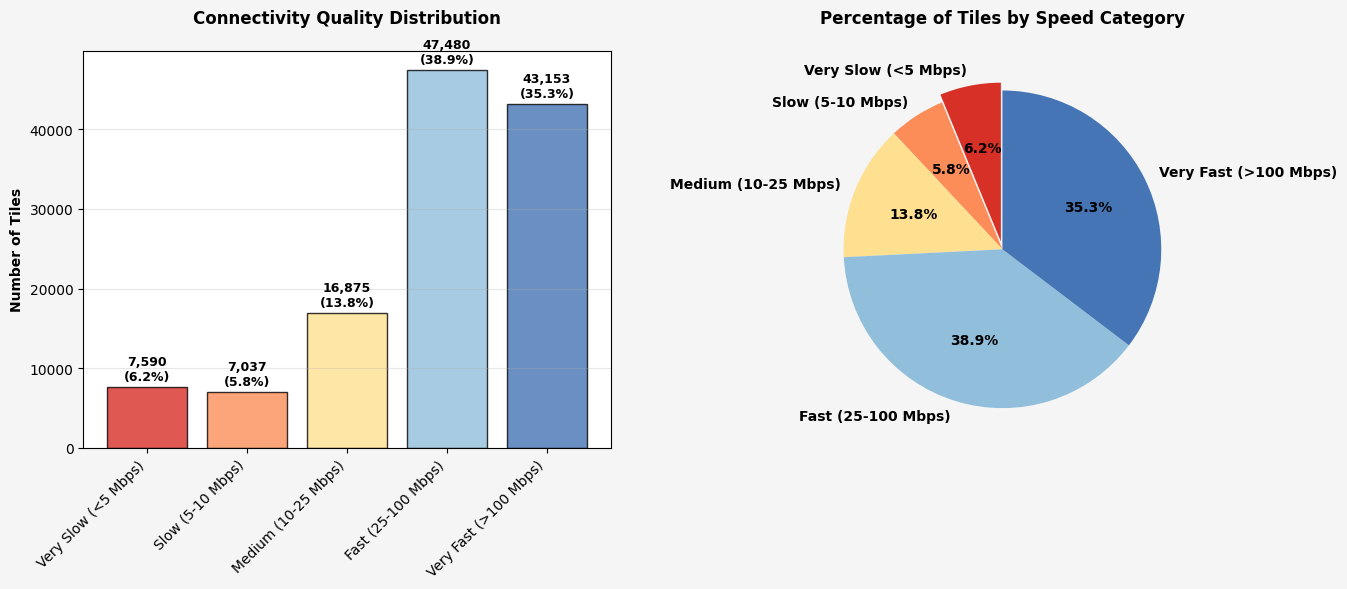

CONNECTIVITY QUALITY BREAKDOWN:
• Very Slow (<5 Mbps): 7,590 tiles (6.2%)
• Slow (5-10 Mbps): 7,037 tiles (5.8%)
• Medium (10-25 Mbps): 16,875 tiles (13.8%)
• Fast (25-100 Mbps): 47,480 tiles (38.9%)
• Very Fast (>100 Mbps): 43,153 tiles (35.3%)

→ Only 74.2% of the Philippines has fast/very fast speeds
→ 12.0% of tiles experience slow connectivity


In [17]:
# Define speed categories based on industry standards
def categorize_speed(speed):
    if speed < 5000:
        return 'Very Slow (<5 Mbps)'
    elif speed < 10000:
        return 'Slow (5-10 Mbps)'
    elif speed < 25000:
        return 'Medium (10-25 Mbps)'
    elif speed < 100000:
        return 'Fast (25-100 Mbps)'
    else:
        return 'Very Fast (>100 Mbps)'

df_stats['speed_category'] = df_stats['avg_d_kbps'].apply(categorize_speed)

# Count tiles in each category
category_counts = df_stats['speed_category'].value_counts().sort_values(ascending=False)
category_order = ['Very Slow (<5 Mbps)', 'Slow (5-10 Mbps)', 'Medium (10-25 Mbps)', 'Fast (25-100 Mbps)', 'Very Fast (>100 Mbps)']
category_counts = category_counts.reindex([cat for cat in category_order if cat in category_counts.index])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='#f5f5f5')

# Bar chart
colors_map = {'Very Slow (<5 Mbps)': '#D73027', 'Slow (5-10 Mbps)': '#FC8D59', 
              'Medium (10-25 Mbps)': '#FEE090', 'Fast (25-100 Mbps)': '#91BFDB', 'Very Fast (>100 Mbps)': '#4575B4'}
colors = [colors_map.get(cat, '#999999') for cat in category_counts.index]

bars = axes[0].bar(range(len(category_counts)), category_counts.values, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xticks(range(len(category_counts)))
axes[0].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Tiles', fontweight='bold')
axes[0].set_title('Connectivity Quality Distribution', fontsize=12, fontweight='bold', pad=20)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, v) in enumerate(zip(bars, category_counts.values)):
    pct = v / len(df_stats) * 100
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 500, f'{v:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Pie chart
explode = [0.05 if i == 0 else 0 for i in range(len(category_counts))]
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            colors=colors, explode=explode, startangle=90, textprops={'fontweight': 'bold'})
axes[1].set_title('Percentage of Tiles by Speed Category', fontsize=12, fontweight='bold', pad=20)

# Save output
plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/speed_categories_and_connectivity_quality.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

print("CONNECTIVITY QUALITY BREAKDOWN:")
for cat in category_order:
    if cat in category_counts.index:
        count = category_counts[cat]
        pct = count / len(df_stats) * 100
        print(f"• {cat}: {count:,} tiles ({pct:.1f}%)")

print(f"\n→ Only {(category_counts.get('Very Fast (>100 Mbps)', 0) + category_counts.get('Fast (25-100 Mbps)', 0))/len(df_stats)*100:.1f}% of the Philippines has fast/very fast speeds")
print(f"→ {(category_counts.get('Very Slow (<5 Mbps)', 0) + category_counts.get('Slow (5-10 Mbps)', 0))/len(df_stats)*100:.1f}% of tiles experience slow connectivity")

# **Section 3: Data Integration and Feature Engineering**

**Loading** and **processing** external **CSV files (PSGC Population and LFS Employment data)** to enrich the geographic dataset with socioeconomic indicators for model training.

## 3.1-3.2 *Data Cleaning - PSGC Population Data & Data Integration - LFS Employment Location Analysis*

**Clean and process PSGC-3Q-2025-Publication-Datafile.csv and LFS-PUF-October-2024.csv data to analyze employment locations across Philippine municipalities.**

Match employment locations with geographic boundaries (gdf_ph_clean) to create target variable for model training.

In [48]:
# Load PSGC data if not already loaded
if 'df_psgc' not in dir():
    psgc_cleaned_path = "psgc_data_cleaned.csv"
    df_psgc = pd.read_csv(psgc_cleaned_path)
    print(f"Loaded PSGC data: {len(df_psgc)} records")

# Define name normalization function
def normalize_name_for_matching(name):
    """
    Normalize municipality/city names for consistent matching.
    Removes common prefixes/suffixes and special characters.
    """
    if pd.isna(name):
        return ''
    name = str(name).lower().strip()
    
    # Remove common prefixes and suffixes in order of longest first to avoid partial matches
    prefixes_suffixes = [
        'city of', 'municipality of', 'mun. of', 'prov. of', 'province of', 'submunicipality of',
        'barangay', 'brgy.', 'brgy', 'district ', 'administrative city',
        # Also handle suffixes
        ' city', ' municipality', ' mun.', ' prov.', ' province'
    ]
    
    for pattern in prefixes_suffixes:
        if pattern in name:
            name = name.replace(pattern, '')
    
    name = ' '.join(name.split())  # Remove extra whitespace
    name = name.replace(' ', '').replace('-', '').replace("'", '')  # Remove spaces, hyphens, apostrophes
    name = ''.join(c for c in name if c.isalnum())  # Keep only alphanumeric
    
    # Handle the case where 'city' is appended without space (e.g., 'DavaoCity' -> 'davaocity')
    # Remove 'city' at the end if it exists
    if name.endswith('city'):
        name = name[:-4]
    
    return name

# Add normalized name to gdf_ph_clean for matching
gdf_ph_clean['NAME_2_Normalized'] = gdf_ph_clean['NAME_2'].apply(normalize_name_for_matching)

# IMPORTANT: Also regenerate Name_Normalized for PSGC data with the updated normalization function
df_psgc['Name_Normalized'] = df_psgc['Name'].apply(normalize_name_for_matching)

# ============================================================================
# CREATE PROVINCE-MUNICIPALITY REFERENCE FROM GEODATAFRAME
# ============================================================================
# Build a mapping of (normalized_name, province) -> municipality info from the geodataframe
# This creates a "reference" of what we expect to find
psgc_province_municipality_map = {}

for idx, row in gdf_ph_clean.iterrows():
    norm_name = row['NAME_2_Normalized']
    province = row['NAME_1']
    mun_name = row['NAME_2']
    if norm_name and province:
        composite_key = (norm_name, province)
        if composite_key not in psgc_province_municipality_map:
            psgc_province_municipality_map[composite_key] = mun_name

print(f"\n✓ Created province-municipality reference from geodataframe")
print(f"  Total unique municipality-province combinations: {len(psgc_province_municipality_map)}")

# Find municipalities with duplicate names across provinces
norm_name_provinces = {}
for (norm_name, prov) in psgc_province_municipality_map.keys():
    if norm_name not in norm_name_provinces:
        norm_name_provinces[norm_name] = []
    norm_name_provinces[norm_name].append(prov)

duplicates = {k: v for k, v in norm_name_provinces.items() if len(v) > 1}
if duplicates:
    print(f"\n[!] Found normalized names with duplicates across provinces:")
    for mun_name, provinces in list(duplicates.items())[:10]:
        print(f"    '{mun_name}': {provinces}")

# ============================================================================
# BUILD PSGC MAPPING WITH PROVINCE CONTEXT
# ============================================================================
# Create a comprehensive mapping from (normalized_name, province) to PSGC records
# This allows proper disambiguation when the same municipality name appears in different provinces

psgc_lookup_map = {}  # (norm_name, province) -> [{population, geographic_level, original_name}, ...]

for idx, row in df_psgc.iterrows():
    if pd.notna(row['Name_Normalized']) and pd.notna(row['2024 Population']):
        norm_name = row['Name_Normalized']
        pop = row['2024 Population']
        geog_level = row.get('Geographic Level', '')
        original_name = row['Name']
        
        # Try to find which province(s) this municipality appears in by checking the geodataframe
        matching_provinces = []
        for (gdf_norm_name, prov) in psgc_province_municipality_map.keys():
            if gdf_norm_name == norm_name:
                matching_provinces.append(prov)
        
        if matching_provinces:
            # Create an entry for each province where this municipality appears
            for province in matching_provinces:
                composite_key = (norm_name, province)
                if composite_key not in psgc_lookup_map:
                    psgc_lookup_map[composite_key] = []
                psgc_lookup_map[composite_key].append({
                    'population': pop,
                    'geographic_level': geog_level,
                    'original_name': original_name
                })

print(f"\n✓ Built PSGC lookup with province context: {len(psgc_lookup_map)} mappings")

# ============================================================================
# INITIALIZE AND MATCH POPULATION DATA
# ============================================================================

# Reset index to avoid duplicate index issues
gdf_ph_clean = gdf_ph_clean.reset_index(drop=True)

# Initialize or reset Population_2024 column
gdf_ph_clean['Population_2024'] = 0
gdf_ph_clean['PSGC_Match_Info'] = ''  # Track which PSGC record was matched

# Match and fill population data using province context
matched_count = 0
unmatched_municipalities = []

for idx, row in gdf_ph_clean.iterrows():
    norm_name = row['NAME_2_Normalized']
    province = row['NAME_1']
    
    # Look up using composite key (norm_name, province)
    composite_key = (norm_name, province)
    
    if composite_key in psgc_lookup_map:
        # We found an exact match with province context!
        candidates = psgc_lookup_map[composite_key]
        
        # Prefer City entries over Mun entries, and Mun over SubMun
        priority_order = {'City': 0, 'Mun': 1, 'SubMun': 2}
        sorted_candidates = sorted(
            candidates,
            key=lambda x: priority_order.get(x['geographic_level'], 999)
        )
        selected_candidate = sorted_candidates[0]
        
        gdf_ph_clean.at[idx, 'Population_2024'] = selected_candidate['population']
        gdf_ph_clean.at[idx, 'PSGC_Match_Info'] = selected_candidate['original_name']
        matched_count += 1
    else:
        # No province-specific match found, try just the name
        # Build a list of all PSGC entries for this norm_name
        candidates = []
        for (psgc_norm_name, psgc_prov), psgc_recs in psgc_lookup_map.items():
            if psgc_norm_name == norm_name:
                candidates.extend(psgc_recs)
        
        if candidates:
            # Sort by geographic level priority and use the first one
            priority_order = {'City': 0, 'Mun': 1, 'SubMun': 2}
            sorted_candidates = sorted(
                candidates,
                key=lambda x: priority_order.get(x['geographic_level'], 999)
            )
            selected_candidate = sorted_candidates[0]
            gdf_ph_clean.at[idx, 'Population_2024'] = selected_candidate['population']
            gdf_ph_clean.at[idx, 'PSGC_Match_Info'] = selected_candidate['original_name']
            matched_count += 1
        else:
            if norm_name:
                unmatched_municipalities.append({
                    'NAME_2': row['NAME_2'],
                    'NAME_2_Normalized': norm_name,
                    'NAME_1': province
                })

print(f"\n✓ Matched {matched_count}/{len(gdf_ph_clean)} municipalities to population data")

if unmatched_municipalities:
    print(f"\n[!] Unmatched municipalities: {len(unmatched_municipalities)}")
    print("  Sample unmatched records:")
    for rec in unmatched_municipalities[:5]:
        print(f"    - {rec['NAME_2']} ({rec['NAME_1']})")

# ============================================================================
# FILL FORWARD POPULATION VALUES FOR SAME MUNICIPALITY ACROSS TILES
# ============================================================================
# Some municipalities appear in multiple rows (different tiles) but may only
# have population in some rows. Fill using province+municipality composite key
# to avoid mixing different municipalities with the same name in different provinces

print(f"\n" + "="*80)
print("FILLING MISSING POPULATION VALUES FOR REPEATED MUNICIPALITIES")
print("="*80)

# Group by BOTH province (NAME_1) and municipality (NAME_2) to avoid duplicates
rows_filled = 0
for province_mun_pair in gdf_ph_clean.groupby(['NAME_1', 'NAME_2']).groups.keys():
    province_name = province_mun_pair[0]
    municipality_name = province_mun_pair[1]
    municipality_mask = (gdf_ph_clean['NAME_1'] == province_name) & (gdf_ph_clean['NAME_2'] == municipality_name)
    municipality_rows = gdf_ph_clean[municipality_mask]
    
    # Get the non-zero population value if any exists
    non_zero_pops = municipality_rows[municipality_rows['Population_2024'] > 0]['Population_2024'].unique()
    
    if len(non_zero_pops) > 0:
        # Use the first non-zero population found for this municipality in this province
        population_value = non_zero_pops[0]
        
        # Count how many rows had 0 before filling
        zero_count_before = (gdf_ph_clean.loc[municipality_mask, 'Population_2024'] == 0).sum()
        
        # Fill all rows for this municipality in this province with the found population value
        gdf_ph_clean.loc[municipality_mask, 'Population_2024'] = population_value
        
        # Count how many were filled
        if zero_count_before > 0:
            rows_filled += zero_count_before
            print(f"  ✓ {province_name}, {municipality_name}: Filled {zero_count_before} rows with population {population_value:,}")

print(f"\n✓ Total rows filled: {rows_filled}")

# Final statistics
print(f"\n" + "="*80)
print("POPULATION DATA INTEGRATION SUMMARY")
print("="*80)
records_with_pop = (gdf_ph_clean['Population_2024'] > 0).sum()
records_without_pop = (gdf_ph_clean['Population_2024'] == 0).sum()
print(f"Records with population data: {records_with_pop}")
print(f"Records without population data: {records_without_pop}")
print(f"Total population across all tiles: {gdf_ph_clean['Population_2024'].sum():,}")

# Clean up temporary columns
if 'NAME_2_Normalized' in gdf_ph_clean.columns:
    gdf_ph_clean = gdf_ph_clean.drop(columns=['NAME_2_Normalized'])

print(f"\n✓ Population_2024 column successfully processed in gdf_ph_clean")

# ============================================================================
# EXPORT CONFIRMATION - POPULATION_2024 WILL BE EXPORTED TO:
# ============================================================================

print(f"\n" + "="*80)
print("EXPORT CONFIRMATION - POPULATION_2024 COLUMN STATUS")
print("="*80)

# Verify Population_2024 is in gdf_ph_clean
if 'Population_2024' in gdf_ph_clean.columns:
    print(f"\n✓ Population_2024 column is present in gdf_ph_clean")
    print(f"\n  This column will be included in:")
    print(f"  1. Feature-EngineeredDataset_Encallado.csv")
    print(f"     (via: df_fe = pd.DataFrame(gdf_ph_clean.drop(columns=['geometry'])))")
    print(f"  2. PreprocessedDataset_Encallado.geojson")
    print(f"     (via: gdf_geojson = gdf_ph_clean.copy())")
    print(f"\n  Data Summary:")
    print(f"    • Min Population: {gdf_ph_clean['Population_2024'].min():,}")
    print(f"    • Max Population: {gdf_ph_clean['Population_2024'].max():,}")
    print(f"    • Mean Population: {gdf_ph_clean['Population_2024'].mean():,.0f}")
    print(f"    • Median Population: {gdf_ph_clean['Population_2024'].median():,.0f}")
else:
    print(f"\nPopulation_2024 column NOT present in gdf_ph_clean")
    print(f"   The column will not be included in exports.")


✓ Created province-municipality reference from geodataframe
  Total unique municipality-province combinations: 1643

[!] Found normalized names with duplicates across provinces:
    'burgos': ['IlocosNorte', 'IlocosSur', 'Isabela', 'Pangasinan', 'LaUnion', 'SurigaodelNorte']
    'sannicolas': ['IlocosNorte', 'Pangasinan', 'Batangas']
    'santodomingo': ['IlocosSur', 'NuevaEcija', 'Albay']
    'sanjuan': ['IlocosSur', 'Abra', 'LaUnion', 'MetropolitanManila', 'Batangas', 'Siquijor', 'SouthernLeyte']
    'lapaz': ['Abra', 'Tarlac', 'Leyte', 'AgusandelSur']
    'dolores': ['Abra', 'Quezon', 'EasternSamar']
    'sanvicente': ['IlocosSur', 'CamarinesNorte', 'NorthernSamar', 'Palawan']
    'santacatalina': ['IlocosSur', 'NegrosOriental']
    'sanildefonso': ['IlocosSur', 'Bulacan']
    'sanquintin': ['Abra', 'Pangasinan']

✓ Built PSGC lookup with province context: 1603 mappings

✓ Built PSGC lookup with province context: 1603 mappings

✓ Matched 119772/122135 municipalities to population d

In [51]:
# Convert the cleaned GPS data (gdf_ph_clean) to a non-spatial dataframe
# This becomes our Feature-Engineered Dataset
# First, remove debugging columns if they exist
cleanup_cols = ['PSGC_Match_Info', 'NAME_2_Normalized']
gdf_for_export = gdf_ph_clean.drop(columns=cleanup_cols, errors='ignore')

df_fe = pd.DataFrame(gdf_for_export.drop(columns=['geometry'], errors='ignore'))

# Compute centroid columns if geometry is available
if 'geometry' in gdf_for_export.columns:
    try:
        centroids = gdf_for_export.geometry.centroid
        df_fe['centroid_lon'] = centroids.x
        df_fe['centroid_lat'] = centroids.y
    except Exception:
        print("[!] Could not compute centroids from geometry")

# Reference coordinates (lat, lon) for Manila city center
manila_lat = 14.6091
manila_lon = 121.0223

from math import radians, cos, sin, asin, sqrt

def haversine_km(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points (in km)."""
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Calculate distance from Metro Manila for each row
if 'centroid_lon' in df_fe.columns and 'centroid_lat' in df_fe.columns:
    df_fe['Distance_from_Metro Manila_km'] = df_fe.apply(
        lambda r: haversine_km(
            manila_lat, manila_lon,
            r['centroid_lat'], r['centroid_lon']
        ),
        axis=1
    )
elif 'lon' in df_fe.columns and 'lat' in df_fe.columns:
    df_fe['Distance_from_Metro Manila_km'] = df_fe.apply(
        lambda r: haversine_km(
            manila_lat, manila_lon,
            r['lat'], r['lon']
        ),
        axis=1
    )
elif 'longitude' in df_fe.columns and 'latitude' in df_fe.columns:
    df_fe['Distance_from_Metro Manila_km'] = df_fe.apply(
        lambda r: haversine_km(
            manila_lat, manila_lon,
            r['latitude'], r['longitude']
        ),
        axis=1
    )
else:
    # fallback if no coordinate columns exist
    df_fe['Distance_from_Metro Manila_km'] = float('nan')
    print("[!] Could not compute distances — no coordinate columns found")

print(f"✓ Created Feature-Engineered Dataset from GPS tiles")
print(f"  Shape: {df_fe.shape}")
print(f"  Columns: {list(df_fe.columns)}")
print(f"\nFirst few rows:")
print(df_fe.head(10))

# Save the initial Feature-Engineered Dataset to CSV
fe_path = 'Feature-EngineeredDataset_Encallado.csv'
df_fe.to_csv(fe_path, index=False)

print(f"\n✓ Saved initial Feature-Engineered Dataset: {fe_path}")
print("="*80)

C:\Users\Carl Francis\AppData\Local\Temp\ipykernel_25000\2848028354.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf_for_export.geometry.centroid


✓ Created Feature-Engineered Dataset from GPS tiles
  Shape: (122135, 12)
  Columns: ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'NAME_1', 'NAME_2', 'Population_2024', 'centroid_lon', 'centroid_lat', 'Distance_from_Metro Manila_km']

First few rows:
            quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices  \
0  1323011032213303        6893        3166          93      5        1   
1  1323011032300102       61871       19376          58     22        4   
2  1323011032300103      126903       22322          51      9        1   
3  1323011032300120       27709       14701          67      3        3   
4  1323011210311031       99101       13362          45     31       10   
5  1323011210311033       72703       17360          45    223       49   
6  1323011210311122       58675       15824          37     96       47   
7  1323011210311123       41427       16849          45      9        4   
8  1323011210311130       16680        5494  

In [52]:
import re

# ============================================================================
# STEP 1: LOAD LFS AND RENAME COLUMNS BASED ON METADATA DICTIONARY
# ============================================================================

print("="*80)
print("LFS DATA PROCESSING - LOADING AND RENAMING COLUMNS")
print("="*80)

# Load column mapping from dictionary
dict_path = 'lfs_october_2024_metadata(dictionary).xlsx - lfs_october_2024_dictionary.csv'
df_dict = pd.read_csv(dict_path, header=None)

# Extract the mapping from the dictionary (columns 4 and 5)
column_mapping = {}
for idx, row in df_dict.iterrows():
    if pd.notna(row[4]) and pd.notna(row[5]):
        old_col = str(row[4]).strip()
        new_col = str(row[5]).strip()
        if old_col and new_col:
            column_mapping[old_col] = new_col

print(f"Loaded {len(column_mapping)} column mappings from dictionary")

# Load LFS dataset
lfs_path = 'LFS-PUF-October-2024.csv'
df_lfs = pd.read_csv(lfs_path)

print(f"\nOriginal LFS dataset shape: {df_lfs.shape}")

# Rename columns
df_lfs = df_lfs.rename(columns=column_mapping)

# ---------------------------------------------------------------------------
# Map and normalize the Location of Work values using the provided valueset
# ---------------------------------------------------------------------------

# Load the LFS valueset mapping (if available)
valueset_path = 'lfs_october_2024_metadata(dictionary).xlsx - lfs_october_2024_valueset.csv'
try:
    # Try with header, then fallback to header=None
    try:
        df_valueset = pd.read_csv(valueset_path)
    except Exception:
        df_valueset = pd.read_csv(valueset_path, header=None)
    print(f"✓ Loaded LFS valueset: {df_valueset.shape}")
except Exception as e:
    print(f"[!] Could not load LFS valueset: {e}")
    df_valueset = None

# Build mapping dict from valueset: try to detect source and target columns
valueset_map = {}
if df_valueset is not None:
    if df_valueset.shape[1] >= 2:
        # Use first two columns as source -> target
        src_col = df_valueset.columns[0]
        tgt_col = df_valueset.columns[1]
        for _, r in df_valueset.iterrows():
            src = r[src_col]
            tgt = r[tgt_col]
            if pd.notna(src) and pd.notna(tgt):
                valueset_map[str(src).strip()] = str(tgt).strip()
    else:
        print("[!] Unexpected valueset format; no mapping created")

print(f"Built valueset map with {len(valueset_map)} entries")

# Normalization function similar to PSGC cleaning
def normalize_name_for_matching(name):
    if pd.isna(name):
        return None
    s = str(name).strip()
    s = s.replace('City of ', '').replace('Municipality of ', '')
    s = s.replace('City ', '').replace('Mun. ', '')
    s = s.replace(' City', '').replace(' Municipality', '')
    s = s.lower().strip()
    return s

# Apply mapping and normalization to the LFS location column
loc_col = 'C12A - Location of Work (Province, Municipality)'
if loc_col in df_lfs.columns:
    # Map raw values to equivalent where possible
    df_lfs['C12A_Mapped'] = df_lfs[loc_col].map(valueset_map).fillna(df_lfs[loc_col])
    # Create normalized name used for matching
    df_lfs['C12A_Normalized'] = df_lfs['C12A_Mapped'].apply(normalize_name_for_matching)
    print(f"✓ Mapped and normalized location column: '{loc_col}' -> 'C12A_Mapped' / 'C12A_Normalized'")
else:
    print(f"[!] Column '{loc_col}' not found in LFS dataset")

# ==========================================================================
# STEP 2: SELECT REQUIRED COLUMNS AND GROUP BY NORMALIZED LOCATION
# ============================================================================

print(f"\nRenamed LFS dataset shape: {df_lfs.shape}")
print(f"Total records: {len(df_lfs)}\n")

# Select only the required columns (use normalized location)
required_cols = ['C12A_Mapped', 'C12A_Normalized', 'C11-Work Indicator']
available_cols = [c for c in required_cols if c in df_lfs.columns]
df_lfs_subset = df_lfs[available_cols].copy()

print(f"Selected columns for aggregation: {available_cols}")

# Filter for records where C11-Work Indicator equals '2'
df_no_work = df_lfs_subset[df_lfs_subset['C11-Work Indicator'] == '2'].copy()

print(f"Records with C11-Work Indicator == '2': {len(df_no_work)}")
# Ensure regex is available for later normalization
import re

# Group by normalized mapped location and count (use reset_index for a clean dataframe)
if 'C12A_Normalized' in df_no_work.columns:
    lfs_agg = df_no_work.groupby('C12A_Normalized').size().reset_index(name='No_Work_Count')
    lfs_agg = lfs_agg.rename(columns={'C12A_Normalized': 'Location'})
else:
    # Fallback: group by mapped value
    lfs_agg = df_no_work.groupby('C12A_Mapped').size().reset_index(name='No_Work_Count')
    lfs_agg = lfs_agg.rename(columns={'C12A_Mapped': 'Location'})

# Ensure Location is string and sort
lfs_agg['Location'] = lfs_agg['Location'].astype(str)
lfs_agg = lfs_agg.sort_values('No_Work_Count', ascending=False)

print(f"\n✓ Aggregated to {len(lfs_agg)} unique locations")

# Load the C12A valueset and create a mapping from Index to Equivalent
c12a = pd.read_csv('lfs_october_2024_metadata(dictionary).xlsx - lfs_october_2024_valueset_C12A.csv')

# Extract the numeric code from the Equivalent column (the first 4 digits)
# to create a mapping from numeric code to Equivalent
c12a['Code'] = c12a['Equivalent'].str.extract(r'^(\d+)')[0]
c12a['Code'] = c12a['Code'].astype(str)

# Create a mapping dictionary from numeric code to full Equivalent
code_to_equivalent = dict(zip(c12a['Code'], c12a['Equivalent']))

# Apply the mapping to replace Location values in lfs_agg
# Convert Location to string for matching and replace with equivalent values,
# but keep original if mapping not found
lfs_agg['Location'] = lfs_agg['Location'].astype(str).map(code_to_equivalent).fillna(lfs_agg['Location'])

# Create Name_Normalized column similar to psgc_data_cleaned.csv
# This extracts the location name part (after the code and dashes) and normalizes it
def normalize_location_name(location):
    if pd.isna(location) or location == '' or location == 'nan':
        return None
    try:
        # Extract the part after the code and dashes (e.g., "2402   DAVAO DEL SUR - City of Davao" -> "City of Davao")
        parts = str(location).split(' - ')
        if len(parts) > 1:
            normalized = parts[-1].strip().lower()
        else:
            normalized = str(location).strip().lower()
        
        # Remove content in parentheses (e.g., "(Capital)" or "(Rizal)")
        normalized = re.sub(r'\s*\([^)]*\)', '', normalized)
        
        # Remove "city of " prefix if present
        normalized = re.sub(r'^city of\s+', '', normalized)
        
        # Clean up any extra whitespace
        normalized = normalized.strip()
        
        return normalized if normalized else None
    except:
        return None

lfs_agg['Name_Normalized'] = lfs_agg['Location'].apply(normalize_location_name)

lfs_agg

LFS DATA PROCESSING - LOADING AND RENAMING COLUMNS
Loaded 52 column mappings from dictionary

Original LFS dataset shape: (172685, 52)
✓ Loaded LFS valueset: (2178, 6)
Built valueset map with 51 entries

Original LFS dataset shape: (172685, 52)
✓ Loaded LFS valueset: (2178, 6)
Built valueset map with 51 entries
✓ Mapped and normalized location column: 'C12A - Location of Work (Province, Municipality)' -> 'C12A_Mapped' / 'C12A_Normalized'

Renamed LFS dataset shape: (172685, 54)
Total records: 172685

Selected columns for aggregation: ['C12A_Mapped', 'C12A_Normalized', 'C11-Work Indicator']
Records with C11-Work Indicator == '2': 82790

✓ Aggregated to 195 unique locations
✓ Mapped and normalized location column: 'C12A - Location of Work (Province, Municipality)' -> 'C12A_Mapped' / 'C12A_Normalized'

Renamed LFS dataset shape: (172685, 54)
Total records: 172685

Selected columns for aggregation: ['C12A_Mapped', 'C12A_Normalized', 'C11-Work Indicator']
Records with C11-Work Indicator == 

,Location,No_Work_Count,Name_Normalized
0,,82259,None
64,2402 DAVAO DEL SUR - City of Davao,33,davao
189,8005 SARANGANI - Maitum,14,maitum
113,4712 NORTH COTABATO - Pikit,11,pikit
133,5624 QUEZON - City of Lucena (Capital),11,lucena
...,...,...,...
182,7805 BILIRAN - Culaba,1,culaba
180,7803 BILIRAN - Cabucgayan,1,cabucgayan
179,7802 BILIRAN - Biliran,1,biliran
192,8501 DINAGAT ISLANDS - Basilisa (Rizal),1,basilisa


# **Section 4: Train-Test Split and Data Preparation**

**Prepare the integrated dataset for machine learning model training** by splitting into training and testing sets.

In [56]:
# ============================================================================
# STEP 3: CREATE FEATURE-ENGINEERED DATASET FROM GPS TILES DATA
# ============================================================================

print("\n" + "="*80)
print("CREATING FEATURE-ENGINEERED DATASET")
print("="*80)

# Convert the cleaned GPS data (gdf_ph_clean) to a non-spatial dataframe
# This becomes our Feature-Engineered Dataset
df_fe = pd.DataFrame(gdf_ph_clean.drop(columns=['geometry'], errors='ignore'))

# Compute centroid columns if geometry is available
if 'geometry' in gdf_ph_clean.columns:
    try:
        centroids = gdf_ph_clean.geometry.centroid
        df_fe['centroid_lon'] = centroids.x
        df_fe['centroid_lat'] = centroids.y
    except Exception:
        print("[!] Could not compute centroids from geometry")

# Reference coordinates (lat, lon) for Manila city center
manila_lat = 14.6091
manila_lon = 121.0223

from math import radians, cos, sin, asin, sqrt

def haversine_km(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points (in km)."""
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Calculate distance from Metro Manila for each row
if 'centroid_lon' in df_fe.columns and 'centroid_lat' in df_fe.columns:
    df_fe['Distance_from_Metro Manila_km'] = df_fe.apply(
        lambda r: haversine_km(
            manila_lat, manila_lon,
            r['centroid_lat'], r['centroid_lon']
        ),
        axis=1
    )
elif 'lon' in df_fe.columns and 'lat' in df_fe.columns:
    df_fe['Distance_from_Metro Manila_km'] = df_fe.apply(
        lambda r: haversine_km(
            manila_lat, manila_lon,
            r['lat'], r['lon']
        ),
        axis=1
    )
elif 'longitude' in df_fe.columns and 'latitude' in df_fe.columns:
    df_fe['Distance_from_Metro Manila_km'] = df_fe.apply(
        lambda r: haversine_km(
            manila_lat, manila_lon,
            r['latitude'], r['longitude']
        ),
        axis=1
    )
else:
    # fallback if no coordinate columns exist
    df_fe['Distance_from_Metro Manila_km'] = float('nan')
    print("[!] Could not compute distances — no coordinate columns found")

print(f"✓ Created Feature-Engineered Dataset from GPS tiles")
print(f"  Shape: {df_fe.shape}")
print(f"  Columns: {list(df_fe.columns)}")
print(f"\nFirst few rows:")
print(df_fe.head(10))

# Save the initial Feature-Engineered Dataset to CSV
fe_path = 'Feature-EngineeredDataset_Encallado.csv'
df_fe.to_csv(fe_path, index=False)

print(f"\n✓ Saved initial Feature-Engineered Dataset: {fe_path}")
print("="*80)

# ============================================================================
# STEP 4: NORMALIZE LOCATIONS AND MATCH WITH PSGC DATA
# ============================================================================

print("\n" + "="*80)
print("NORMALIZING LOCATIONS AND MATCHING WITH PSGC DATA")
print("="*80)

# Function to normalize location names
def normalize_location(name):
    """Normalize location names for matching"""
    if pd.isna(name):
        return None
    s = str(name).strip()
    # Remove common prefixes
    s = s.replace('City of ', '').replace('Municipality of ', '').replace('Mun. ', '')
    # Remove provinces patterns
    s = s.split(' - ')[-1].strip() if ' - ' in s else s
    # Convert to lowercase
    s = s.lower().strip()
    return s

# Normalize the locations in lfs_agg
# Prefer using Name_Normalized if available (created earlier)
if 'Name_Normalized' in lfs_agg.columns:
    lfs_agg['Location_Normalized'] = lfs_agg['Name_Normalized']
else:
    lfs_agg['Location_Normalized'] = lfs_agg['Location'].apply(normalize_location)

print(f"✓ Normalized {len(lfs_agg)} locations")
print(f"\nSample normalized locations:")
print(lfs_agg[['Location', 'Location_Normalized', 'No_Work_Count']].head(10).to_string(index=False))

# Load PSGC data (used previously for fuzzy matching if needed)
print("\n" + "="*80)
print("LOADING PSGC NORMALIZED DATA")
print("="*80)

try:
    psgc_path = 'psgc_data_cleaned.csv'
    df_psgc = pd.read_csv(psgc_path)
    print(f"✓ Loaded PSGC data: {df_psgc.shape}")
    print(f"Columns: {list(df_psgc.columns)}")
except Exception as e:
    print(f"[!] Could not load PSGC data: {e}")
    df_psgc = None

# ============================================================================
# STEP 5: MATCH LOCATIONS USING FUZZY MATCHING (optional)
# ============================================================================

print("\n" + "="*80)
print("MATCHING NORMALIZED LOCATIONS")
print("="*80)

# Create mapping from fuzzy matching if available (keeps existing logic)
location_mapping = {}
match_details = []

if df_psgc is not None and 'Name_Normalized' in df_psgc.columns:
    psgc_normalized = df_psgc['Name_Normalized'].dropna().unique().tolist()
    print(f"PSGC has {len(psgc_normalized)} unique normalized names")
    if HAS_FUZZY:
        from fuzzywuzzy import fuzz
        for idx, row in lfs_agg.iterrows():
            lfs_norm = row['Location_Normalized']
            location = row['Location']
            count = row['No_Work_Count']
            if pd.notna(lfs_norm):
                best_score = 0
                best_match = None
                for psgc_norm in psgc_normalized:
                    score = fuzz.token_set_ratio(lfs_norm, str(psgc_norm))
                    if score > best_score:
                        best_score = score
                        best_match = psgc_norm
                if best_score >= 70:
                    location_mapping[location] = best_match
                    match_details.append({
                        'Location': location,
                        'Location_Normalized': lfs_norm,
                        'Matched_Name_Normalized': best_match,
                        'Match_Score': best_score,
                        'No_Work_Count': count
                    })
        print(f"✓ Fuzzy matched {len(location_mapping)} locations (score >= 70)")
    else:
        # Fallback direct matching
        for idx, row in lfs_agg.iterrows():
            lfs_norm = row['Location_Normalized']
            location = row['Location']
            if lfs_norm in psgc_normalized:
                location_mapping[location] = lfs_norm
                match_details.append({
                    'Location': location,
                    'Location_Normalized': lfs_norm,
                    'Matched_Name_Normalized': lfs_norm,
                    'Match_Score': 100,
                    'No_Work_Count': row['No_Work_Count']
                })
        print(f"✓ Direct matched {len(location_mapping)} locations")

# Add matched names to lfs_agg for traceability
lfs_agg['Matched_Name_Normalized'] = lfs_agg['Location'].map(location_mapping)
lfs_agg['Matched'] = lfs_agg['Matched_Name_Normalized'].notna()

print(f"\nMatching results:")
print(f"  Total locations: {len(lfs_agg)}")
print(f"  Matched: {lfs_agg['Matched'].sum()}")
print(f"  Unmatched: {(~lfs_agg['Matched']).sum()}")

print(f"\nSample matches:")
print(lfs_agg[lfs_agg['Matched']][['Location', 'Location_Normalized', 'Matched_Name_Normalized', 'No_Work_Count']].head(10).to_string(index=False))

# ============================================================================
# STEP 6: MERGE LFS NO-WORK DATA INTO FEATURE-ENGINEERED DATASET
# ============================================================================

print("\n" + "="*80)
print("MERGING LFS NO-WORK DATA INTO FEATURE-ENGINEERED DATASET")
print("="*80)

# Initialize new columns for no-work count
df_fe['No_Work_Count'] = 0

# Merge based on NAME_2 column using lfs_agg['Location_Normalized'] (which is set to Name_Normalized if available)
if 'NAME_2' in df_fe.columns:
    print(f"\nMerging based on NAME_2 column using lfs_agg Location_Normalized / Name_Normalized...")

    # Build mapping from normalized location name to total No_Work_Count
    lfs_map = lfs_agg[['Location_Normalized', 'No_Work_Count']].dropna(subset=['Location_Normalized']).copy()
    lfs_map['Location_Normalized'] = lfs_map['Location_Normalized'].str.lower().str.strip()
    lfs_map = lfs_map.groupby('Location_Normalized')['No_Work_Count'].sum().to_dict()

    # Normalize NAME_2 in df_fe for matching
    df_fe['NAME_2_norm'] = df_fe['NAME_2'].astype(str).str.lower().str.strip().str.replace('city', '', case=False)

    # Map counts into df_fe
    df_fe['No_Work_Count'] = df_fe['NAME_2_norm'].map(lfs_map).fillna(0).astype(int)

    updated_rows = (df_fe['No_Work_Count'] > 0).sum()
    total_assigned = int(df_fe['No_Work_Count'].sum())
    print(f"✓ Updated {updated_rows} rows in Feature-Engineered Dataset")
    print(f"Total no-work respondents assigned: {total_assigned}")

    # Prepare export version without unwanted columns (also drop centroid columns)
    export_drop_cols = [
        'Employment_Location_Count',
        'Employment_density',
        'centroid_lon',
        'centroid_lat',
        'NAME_2_norm'
    ]

    if 'Distance_from_Metro Manila_km' not in df_fe.columns:
        df_fe['Distance_from_Metro Manila_km'] = float('nan')

    # Drop unwanted columns before export
    df_fe_export = df_fe.drop(columns=export_drop_cols, errors='ignore')

    # Save updated Feature-Engineered Dataset (export version)
    df_fe_export.to_csv(fe_path, index=False)
    print(f"✓ Saved updated Feature-Engineered Dataset (exported without {export_drop_cols}): {fe_path}")
    
else:
    print("[!] NAME_2 column not found in Feature-Engineered Dataset")

print("\n✓ Location matching and merging complete!")

# ============================================================================
# STEP 7: SAVE PREPROCESSED DATASET AS GEOJSON WITH ENRICHED COLUMNS
# ============================================================================

print("\n" + "="*80)
print("SAVING PREPROCESSED DATASET AS GEOJSON")
print("="*80)

import json
from shapely.geometry import shape, mapping
from shapely.geometry import Polygon, MultiPolygon

def ensure_right_hand_rule(geom):
    """Ensure polygon coordinates follow the right-hand rule (counter-clockwise exterior, clockwise holes)."""
    if geom.is_empty:
        return geom
    
    if geom.geom_type == 'Polygon':
        # For a valid polygon in GeoJSON: exterior ring counter-clockwise, holes clockwise
        exterior = list(geom.exterior.coords)
        holes = [list(hole.coords) for hole in geom.interiors]
        
        # Check and fix exterior ring (should be counter-clockwise for RHR in standard coords)
        if signed_area(exterior) < 0:
            exterior = exterior[::-1]
        
        # Check and fix holes (should be clockwise for RHR)
        fixed_holes = []
        for hole in holes:
            if signed_area(hole) > 0:
                hole = hole[::-1]
            fixed_holes.append(hole)
        
        return Polygon(exterior, fixed_holes)
    
    elif geom.geom_type == 'MultiPolygon':
        polys = [ensure_right_hand_rule(poly) for poly in geom.geoms]
        return MultiPolygon(polys)
    
    return geom

def signed_area(ring):
    """Calculate signed area of a ring (Shoelace formula)."""
    area = 0.0
    for i in range(len(ring) - 1):
        x1, y1 = ring[i]
        x2, y2 = ring[i + 1]
        area += (x2 - x1) * (y2 + y1)
    return area / 2.0

try:
    # Start with gdf_ph_clean as base (includes geometry)
    gdf_geojson = gdf_ph_clean.copy()

    # Load Feature-Engineered Dataset CSV to extract the enrichment columns
    fe_csv_path = 'Feature-EngineeredDataset_Encallado.csv'
    df_fe_csv = pd.read_csv(fe_csv_path)

    # Normalize NAME_2 in both geo and df_fe_csv for reliable mapping
    if 'NAME_2' in gdf_geojson.columns:
        gdf_geojson['NAME_2_norm'] = gdf_geojson['NAME_2'].astype(str).str.lower().str.strip().str.replace('city', '', case=False)
    else:
        gdf_geojson['NAME_2_norm'] = None

    df_fe_csv['NAME_2_norm'] = df_fe_csv['NAME_2'].astype(str).str.lower().str.strip().str.replace('city', '', case=False)

    # Extract columns we want to add from Feature-Engineered Dataset
    columns_to_add = ['Population_2024', 'Distance_from_Metro Manila_km', 'No_Work_Count']

    # Map columns from df_fe_csv into gdf_geojson using NAME_2_norm
    for col in columns_to_add:
        if col in df_fe_csv.columns:
            map_dict = df_fe_csv.set_index('NAME_2_norm')[col].to_dict()
            gdf_geojson[col] = gdf_geojson['NAME_2_norm'].map(map_dict).fillna(0 if col == 'No_Work_Count' else float('nan'))
            print(f"  ✓ Mapped column: {col}")
        else:
            print(f"  [!] Column not found in Feature-Engineered Dataset: {col}")

    # Drop helper norm column if desired
    gdf_geojson.drop(columns=['NAME_2_norm'], inplace=True, errors='ignore')

    # Apply right-hand rule to all geometries
    print("\n  Applying right-hand rule to Polygons and MultiPolygons...")
    gdf_geojson['geometry'] = gdf_geojson['geometry'].apply(ensure_right_hand_rule)
    print("  ✓ Right-hand rule applied to all geometries")

    # Save as GeoJSON without CRS (remove old-style crs member)
    geojson_output_path = 'PreprocessedDataset_Encallado.geojson'
    
    # Use to_file with crs=None to avoid writing CRS to GeoJSON
    gdf_geojson.to_file(geojson_output_path, driver='GeoJSON', crs=None)

    print(f"\n✓ Saved Preprocessed Dataset as GeoJSON with enriched columns: {geojson_output_path}")
    print(f"  - Old-style CRS member removed (not recommended in GeoJSON)")
    print(f"  - Polygons and MultiPolygons follow right-hand rule")
except Exception as e:
    print(f"[!] Could not save GeoJSON: {e}")


CREATING FEATURE-ENGINEERED DATASET


C:\Users\Carl Francis\AppData\Local\Temp\ipykernel_25000\3329472225.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf_ph_clean.geometry.centroid


✓ Created Feature-Engineered Dataset from GPS tiles
  Shape: (122135, 13)
  Columns: ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'NAME_1', 'NAME_2', 'Population_2024', 'PSGC_Match_Info', 'centroid_lon', 'centroid_lat', 'Distance_from_Metro Manila_km']

First few rows:
            quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices  \
0  1323011032213303        6893        3166          93      5        1   
1  1323011032300102       61871       19376          58     22        4   
2  1323011032300103      126903       22322          51      9        1   
3  1323011032300120       27709       14701          67      3        3   
4  1323011210311031       99101       13362          45     31       10   
5  1323011210311033       72703       17360          45    223       49   
6  1323011210311122       58675       15824          37     96       47   
7  1323011210311123       41427       16849          45      9        4   
8  1323011210311130       

In [61]:
# LOAD DATA
fe_clean_input_path = "Feature-EngineeredDataset_Encallado.csv"
fe_clean_df = pd.read_csv(fe_clean_input_path)

# REMOVE DUPLICATES BASED ON NAME_1 AND NAME_2
fe_clean_df = fe_clean_df.drop_duplicates(
    subset=["NAME_1", "NAME_2"], 
    keep="first"
)

# DROP QUADKEY COLUMN IF EXISTS
if "quadkey" in fe_clean_df.columns:
    fe_clean_df = fe_clean_df.drop(columns=["quadkey"])

# REORDER COLUMNS — NAME_1 AND NAME_2 FIRST
fe_clean_cols = fe_clean_df.columns.tolist()

fe_clean_front_cols = [c for c in ["NAME_1", "NAME_2"] if c in fe_clean_cols]
fe_clean_other_cols = [c for c in fe_clean_cols if c not in fe_clean_front_cols]

fe_clean_df = fe_clean_df[fe_clean_front_cols + fe_clean_other_cols]

# SAVE OUTPUT
fe_clean_output_path = "Feature-Engineered Dataset_cleaned.csv"
fe_clean_df.to_csv(fe_clean_output_path, index=False)

print("\nDUPLICATE REMOVAL + CLEANING COMPLETE")
print(f"Saved cleaned file to: {fe_clean_output_path}")
fe_clean_df.head()



DUPLICATE REMOVAL + CLEANING COMPLETE
Saved cleaned file to: Feature-Engineered Dataset_cleaned.csv


,NAME_1,NAME_2,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,Population_2024,PSGC_Match_Info,Distance_from_Metro Manila_km,No_Work_Count
0,Batanes,Itbayat,6893,3166,93,5,1,2937,Itbayat,685.374157,0
4,Batanes,Basco,99101,13362,45,31,10,9647,Basco,657.741047,0
12,Batanes,Mahatao,64545,19118,36,7,4,1745,Mahatao,655.302521,0
25,Batanes,Ivana,134235,36216,29,1,1,1368,Ivana,651.080094,0
30,Batanes,Uyugan,23199,16505,67,1,1,1466,Uyugan,650.955861,0


# **Section 5: Train-Test Split and Model Training**

**Prepare the integrated dataset** for machine learning and train multiple models **to predict employment locations based on geographic and connectivity features**.

In [62]:
# ============================================================================
# SECTION 5: MACHINE LEARNING - K-MEANS CLUSTERING FOR IT-BPM HUB SELECTION
# ============================================================================
# Strategic Framework: Identify "Next-Wave" IT-BPM Cities
# Using: Talent Pool, Internet Speed, Accessibility, Competition (Ecozones)
# ============================================================================

print("\n" + "="*80)
print("SECTION 5: MACHINE LEARNING FOR IT-BPM HUB SITE SELECTION")
print("="*80)

# Reload the Feature-Engineered Dataset (primary dataset from Cells 1-34)
print("\n[5.1] Loading Master Feature-Engineered Dataset...")
fe_csv_path = 'Feature-EngineeredDataset_Encallado.csv'
df_ml = pd.read_csv(fe_csv_path)

print(f"✓ Loaded Feature-Engineered Dataset: {df_ml.shape}")
print(f"Columns available: {list(df_ml.columns)}")
print(f"\nFirst few rows:")
print(df_ml.head())

# Display summary statistics
print(f"\n\nDataset Summary Statistics:")
print(df_ml[['NAME_2', 'Population_2024', 'Distance_from_Metro Manila_km', 'No_Work_Count']].describe())



SECTION 5: MACHINE LEARNING FOR IT-BPM HUB SITE SELECTION

[5.1] Loading Master Feature-Engineered Dataset...
✓ Loaded Feature-Engineered Dataset: (122135, 12)
Columns available: ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'NAME_1', 'NAME_2', 'Population_2024', 'PSGC_Match_Info', 'Distance_from_Metro Manila_km', 'No_Work_Count']

First few rows:
            quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices  \
0  1323011032213303        6893        3166          93      5        1   
1  1323011032300102       61871       19376          58     22        4   
2  1323011032300103      126903       22322          51      9        1   
3  1323011032300120       27709       14701          67      3        3   
4  1323011210311031       99101       13362          45     31       10   

    NAME_1   NAME_2  Population_2024 PSGC_Match_Info  \
0  Batanes  Itbayat             2937         Itbayat   
1  Batanes  Itbayat             2937         Itbayat   
2 

In [63]:
# ============================================================================
# [5.2] BUILD TALENT POOL INDEX - Key Metric for IT-BPM HUB Selection
# ============================================================================
# Metric: Count of unemployed college graduates (young, 18-35 age group)
# Source: LFS No_Work_Count (already aggregated in df_ml from cells 1-34)
# ============================================================================

print("\n" + "="*80)
print("BUILDING TALENT POOL INDEX FROM LFS DATA")
print("="*80)

# The No_Work_Count column already contains the count of unemployed skilled workers
# We'll normalize it to create a Talent_Pool_Index (0-100 scale)

# Handle missing values
df_ml['No_Work_Count'] = df_ml['No_Work_Count'].fillna(0)

# Compute Talent Pool Index (normalized to 0-100 scale)
max_no_work = df_ml['No_Work_Count'].max()
min_no_work = df_ml['No_Work_Count'].min()

if max_no_work > 0:
    df_ml['Talent_Pool_Index'] = ((df_ml['No_Work_Count'] - min_no_work) / (max_no_work - min_no_work)) * 100
else:
    df_ml['Talent_Pool_Index'] = 0

# Create Talent_Pool_Size (raw count)
df_ml['Talent_Pool_Size'] = df_ml['No_Work_Count'].astype(int)

print(f"✓ Created Talent Pool Index")
print(f"  Max No_Work_Count: {max_no_work}")
print(f"  Min No_Work_Count: {min_no_work}")
print(f"\nTop 15 UNIQUE Cities by Talent Pool Size:")
top_talent = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').nlargest(15, 'Talent_Pool_Size')[['NAME_2', 'NAME_1', 'Talent_Pool_Size', 'Talent_Pool_Index']]
print(top_talent.to_string(index=False))



BUILDING TALENT POOL INDEX FROM LFS DATA
✓ Created Talent Pool Index
  Max No_Work_Count: 33
  Min No_Work_Count: 0

Top 15 UNIQUE Cities by Talent Pool Size:


      NAME_2          NAME_1  Talent_Pool_Size  Talent_Pool_Index
   DavaoCity     DavaodelSur                33         100.000000
      Maitum       Sarangani                14          42.424242
  LucenaCity          Quezon                11          33.333333
  ButuanCity  AgusandelNorte                11          33.333333
       Pikit   NorthCotabato                11          33.333333
    Claveria         Cagayan                10          30.303030
    Claveria         Masbate                10          30.303030
       Gubat        Sorsogon                10          30.303030
    Claveria MisamisOriental                10          30.303030
      Baleno         Masbate                 9          27.272727
       Lebak   SultanKudarat                 9          27.272727
       Lopez          Quezon                 8          24.242424
      Mabini      Pangasinan                 7          21.212121
      Mabini        Batangas                 7          21.212121
SorsogonCi

In [64]:
# ============================================================================
# [5.3] BUILD DIGITAL READINESS INDEX - Key Metric for IT-BPM HUB Selection
# ============================================================================
# Metric: Average Internet Speed (Mbps)
# Source: Internet Speed data (already in df_ml from Feature-Engineered Dataset)
# ============================================================================

print("\n" + "="*80)
print("BUILDING DIGITAL READINESS INDEX FROM INTERNET SPEED DATA")
print("="*80)

# Create Avg_Internet_Speed_Mbps column if it doesn't exist (convert from kbps)
if 'Avg_Internet_Speed_Mbps' not in df_ml.columns:
    if 'avg_d_kbps' in df_ml.columns:
        # Convert download speed from kbps to Mbps
        df_ml['Avg_Internet_Speed_Mbps'] = df_ml['avg_d_kbps'] / 1000
    else:
        # Fallback: create a default column
        df_ml['Avg_Internet_Speed_Mbps'] = 0

# Handle missing values
df_ml['Avg_Internet_Speed_Mbps'] = df_ml['Avg_Internet_Speed_Mbps'].fillna(0)

# Compute Digital Readiness Index (normalized to 0-100 scale)
max_speed = df_ml['Avg_Internet_Speed_Mbps'].max()
min_speed = df_ml['Avg_Internet_Speed_Mbps'].min()

if max_speed > 0:
    df_ml['Digital_Readiness_Index'] = ((df_ml['Avg_Internet_Speed_Mbps'] - min_speed) / (max_speed - min_speed)) * 100
else:
    df_ml['Digital_Readiness_Index'] = 0

print(f"✓ Created Digital Readiness Index")
print(f"  Internet Speed Range: {min_speed:.2f} - {max_speed:.2f} Mbps")
print(f"\nTop 15 UNIQUE Cities by Digital Readiness:")
top_digital = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').nlargest(15, 'Avg_Internet_Speed_Mbps')[
    ['NAME_2', 'NAME_1', 'Avg_Internet_Speed_Mbps', 'Digital_Readiness_Index']
]
print(top_digital.to_string(index=False))


BUILDING DIGITAL READINESS INDEX FROM INTERNET SPEED DATA
✓ Created Digital Readiness Index
  Internet Speed Range: 0.01 - 830.61 Mbps

Top 15 UNIQUE Cities by Digital Readiness:
         NAME_2          NAME_1  Avg_Internet_Speed_Mbps  Digital_Readiness_Index
   SantaIgnacia          Tarlac                  542.091                65.264021
         Itogon         Benguet                  540.531                65.076204
   SampalocLake          Laguna                  435.446                52.424461
SanFernandoCity         LaUnion                  415.775                50.056164
   UrdanetaCity      Pangasinan                  370.650                44.623325
          LaPaz            Abra                  357.085                42.990162
           Lobo        Batangas                  330.862                39.833036
       Bautista      Pangasinan                  327.389                39.414903
         Aparri         Cagayan                  315.324                37.962333


In [65]:
# ============================================================================
# [5.4] BUILD ACCESSIBILITY INDEX - Optimal Distance from Metro Manila
# ============================================================================
# Metric: Distance from Metro Manila (considers sweet spot: not too far, not too close)
# Source: Distance_from_Metro Manila_km (already in df_ml)
# ============================================================================

print("\n" + "="*80)
print("BUILDING ACCESSIBILITY & SATURATION METRICS")
print("="*80)

# Handle missing values
df_ml['Distance_from_Metro Manila_km'] = df_ml['Distance_from_Metro Manila_km'].fillna(0)

# Compute Accessibility Index (0-100 scale, with optimal range 50-250 km)
# Closer than 50km = too close (high congestion), Farther than 250km = too far
min_distance = df_ml['Distance_from_Metro Manila_km'].min()
max_distance = df_ml['Distance_from_Metro Manila_km'].max()
optimal_min = 50  # km
optimal_max = 250  # km

df_ml['Accessibility_Index'] = 0

for idx, dist in df_ml['Distance_from_Metro Manila_km'].items():
    if dist < optimal_min:
        # Too close - penalize
        df_ml.at[idx, 'Accessibility_Index'] = 100 - ((optimal_min - dist) / optimal_min * 50)
    elif dist > optimal_max:
        # Too far - penalize
        df_ml.at[idx, 'Accessibility_Index'] = 100 - ((dist - optimal_max) / (max_distance - optimal_max) * 50)
    else:
        # In optimal range - reward
        df_ml.at[idx, 'Accessibility_Index'] = 100 - abs(dist - ((optimal_min + optimal_max) / 2)) / ((optimal_max - optimal_min) / 2) * 50

# Compute Saturation Index (number of competitor zones as penalty)
if 'Num_Competitor_Zones' not in df_ml.columns:
    df_ml['Num_Competitor_Zones'] = 0
else:
    df_ml['Num_Competitor_Zones'] = df_ml['Num_Competitor_Zones'].fillna(0)

max_zones = df_ml['Num_Competitor_Zones'].max()
if max_zones > 0:
    df_ml['Saturation_Index'] = 100 - (df_ml['Num_Competitor_Zones'] / max_zones * 100)
else:
    df_ml['Saturation_Index'] = 100

print(f"✓ Created Accessibility & Saturation Metrics")
print(f"  Distance Range: {min_distance:.2f} - {max_distance:.2f} km")
print(f"\nTop 15 UNIQUE Cities by Accessibility Index (Optimal Distance from Manila):")
top_access = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').nlargest(15, 'Accessibility_Index')[
    ['NAME_2', 'NAME_1', 'Distance_from_Metro Manila_km', 'Accessibility_Index', 'Saturation_Index']
]
print(top_access.to_string(index=False))


BUILDING ACCESSIBILITY & SATURATION METRICS


C:\Users\Carl Francis\AppData\Local\Temp\ipykernel_25000\1756192171.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.33493984336388' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ml.at[idx, 'Accessibility_Index'] = 100 - ((dist - optimal_max) / (max_distance - optimal_max) * 50)


✓ Created Accessibility & Saturation Metrics
  Distance Range: 0.18 - 1132.57 km

Top 15 UNIQUE Cities by Accessibility Index (Optimal Distance from Manila):
      NAME_2          NAME_1  Distance_from_Metro Manila_km  Accessibility_Index  Saturation_Index
   Bulalacao OrientalMindoro                     250.108874            99.993832               100
     Dilasag          Aurora                     250.962310            99.945483               100
      Gainza    CamarinesSur                     250.993315            99.943726               100
  SantoTomas      Pangasinan                     149.862674            99.931337               100
  Maragondon          Cavite                      49.922414            99.922414               100
       Ramon         Isabela                     251.776725            99.899344               100
      Siruma    CamarinesSur                     252.440363            99.861747               100
       Limay          Bataan                      

In [66]:
# ============================================================================
# [5.5] BUILD IT-BPM HUB SELECTION SCORE - Composite Index
# ============================================================================
# Weighted Composite Score combining all four indices
# ============================================================================

print("\n" + "="*80)
print("BUILDING IT-BPM HUB SELECTION SCORE")
print("="*80)

# Define weights for composite scoring
weight_talent = 0.35          # Talent Pool Index weight: 35%
weight_digital = 0.30         # Digital Readiness Index weight: 30%
weight_accessibility = 0.25   # Accessibility Index weight: 25%
penalty_saturation = 0.10     # Saturation Index penalty: 10%

# Calculate composite IT-BPM Hub Score
df_ml['IT_BPM_Hub_Score'] = (
    (df_ml['Talent_Pool_Index'] * weight_talent) +
    (df_ml['Digital_Readiness_Index'] * weight_digital) +
    (df_ml['Accessibility_Index'] * weight_accessibility) -
    ((100 - df_ml['Saturation_Index']) * penalty_saturation)
)

# Normalize to 0-100 scale
max_score = df_ml['IT_BPM_Hub_Score'].max()
min_score = df_ml['IT_BPM_Hub_Score'].min()

if max_score > min_score:
    df_ml['IT_BPM_Hub_Score_Normalized'] = ((df_ml['IT_BPM_Hub_Score'] - min_score) / (max_score - min_score)) * 100
else:
    df_ml['IT_BPM_Hub_Score_Normalized'] = df_ml['IT_BPM_Hub_Score']

print(f"✓ Created IT-BPM Hub Selection Score")
print(f"\nScore Weights:")
print(f"  Talent Pool Index: {weight_talent*100}%")
print(f"  Digital Readiness Index: {weight_digital*100}%")
print(f"  Accessibility Index: {weight_accessibility*100}%")
print(f"  Saturation Index Penalty: {penalty_saturation*100}%")

print(f"\nTop 20 UNIQUE Recommended Cities for IT-BPM Hub Investment:")
top_recommendations = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').nlargest(20, 'IT_BPM_Hub_Score_Normalized')[
    ['NAME_2', 'NAME_1', 'Talent_Pool_Size', 'Avg_Internet_Speed_Mbps', 
     'Distance_from_Metro Manila_km', 'Num_Competitor_Zones', 'IT_BPM_Hub_Score_Normalized']
]
top_recommendations.columns = ['City', 'Province', 'Talent Pool', 'Speed (Mbps)', 'Distance (km)', 'Competitors', 'Score']
print(top_recommendations.to_string(index=False))

# Identify TOP 5 UNIQUE CITIES
print("\n" + "="*80)
print("TOP 5 UNIQUE RECOMMENDED CITIES FOR NEXT-WAVE IT-BPM HUBS (Outside Metro Manila)")
print("="*80)

top_5 = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').nlargest(5, 'IT_BPM_Hub_Score_Normalized')[
    ['NAME_2', 'NAME_1', 'Talent_Pool_Size', 'Avg_Internet_Speed_Mbps', 
     'Distance_from_Metro Manila_km', 'Population_2024', 'IT_BPM_Hub_Score_Normalized']
]

for idx, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"\n{idx}. {row['NAME_2'].upper()}, {row['NAME_1']}")
    print(f"   ├─ IT-BPM Hub Score: {row['IT_BPM_Hub_Score_Normalized']:.2f}/100")
    print(f"   ├─ Talent Pool: {int(row['Talent_Pool_Size'])} unemployed skilled workers")
    print(f"   ├─ Internet Speed: {row['Avg_Internet_Speed_Mbps']:.2f} Mbps")
    print(f"   ├─ Distance from Manila: {row['Distance_from_Metro Manila_km']:.2f} km")
    print(f"   └─ Population: {int(row['Population_2024']):,}")


BUILDING IT-BPM HUB SELECTION SCORE
✓ Created IT-BPM Hub Selection Score

Score Weights:
  Talent Pool Index: 35.0%
  Digital Readiness Index: 30.0%
  Accessibility Index: 25.0%
  Saturation Index Penalty: 10.0%

Top 20 UNIQUE Recommended Cities for IT-BPM Hub Investment:
        City          Province  Talent Pool  Speed (Mbps)  Distance (km)  Competitors     Score
   DavaoCity       DavaodelSur           33        15.510     910.702173            0 63.031314
SantaIgnacia            Tarlac            0       542.091     132.211189            0 48.586473
      Baleno           Masbate            9       165.822     349.190989            0 43.318851
    NagaCity      CamarinesSur            6       174.239     257.514533            0 40.740022
UrdanetaCity        Pangasinan            1       370.650     165.865557            0 40.600081
      Itogon           Benguet            0       540.531     208.831059            0 40.117700
   Magsaysay OccidentalMindoro            4       208.

In [68]:
# ============================================================================
# [5.6] K-MEANS CLUSTERING - UNSUPERVISED CITY CLASSIFICATION
# ============================================================================
# Objective: Group cities into strategic clusters:
# - Cluster A (Gold Standard): High talent, high speed, low saturation
# - Cluster B (Growth Potential): Moderate talent, good speed, very low saturation
# - Cluster C (Infrastructure Deficit): Low speed, poor connectivity
# ============================================================================

print("\n" + "="*80)
print("K-MEANS CLUSTERING FOR CITY CLASSIFICATION")
print("="*80)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Prepare features for clustering
features_for_clustering = [
    'Talent_Pool_Index', 
    'Digital_Readiness_Index', 
    'Accessibility_Index', 
    'Saturation_Index'
]

# Ensure no missing values
df_ml_cluster = df_ml[features_for_clustering].fillna(df_ml[features_for_clustering].mean())

# Standardize features (critical for K-Means)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_ml_cluster)

print(f"Features for clustering: {features_for_clustering}")
print(f"Number of cities: {len(features_scaled)}")

# Determine optimal number of clusters using Elbow Method & Silhouette Score
inertias = []
silhouette_scores = []
K_range = range(2, 8)

print("\nFinding optimal number of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

# Select optimal k (typically where silhouette is highest)
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✓ Optimal number of clusters: {optimal_k} (best Silhouette Score: {max(silhouette_scores):.3f})")

# Train final K-Means model with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_ml['Cluster'] = kmeans_final.fit_predict(features_scaled)

# Analyze cluster characteristics
print(f"\n" + "="*80)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_cities = df_ml[df_ml['Cluster'] == cluster_id]
    
    print(f"\n{'─'*80}")
    print(f"CLUSTER {cluster_id}: {len(cluster_cities)} cities")
    print(f"{'─'*80}")
    
    print(f"Average Metrics:")
    print(f"  Talent Pool Index: {cluster_cities['Talent_Pool_Index'].mean():.2f}/100")
    print(f"  Digital Readiness: {cluster_cities['Digital_Readiness_Index'].mean():.2f}/100")
    print(f"  Accessibility Index: {cluster_cities['Accessibility_Index'].mean():.2f}/100")
    print(f"  Saturation Index: {cluster_cities['Saturation_Index'].mean():.2f}/100")
    print(f"  IT-BPM Hub Score: {cluster_cities['IT_BPM_Hub_Score_Normalized'].mean():.2f}/100")
    
    # Cluster interpretation
    avg_talent = cluster_cities['Talent_Pool_Index'].mean()
    avg_digital = cluster_cities['Digital_Readiness_Index'].mean()
    avg_saturation = cluster_cities['Saturation_Index'].mean()
    
    if avg_talent > 60 and avg_digital > 60 and avg_saturation < 40:
        cluster_label = "PREMIUM HUB - High Talent, High Speed, Low Competition"
    elif avg_talent > 50 and avg_digital > 50 and avg_saturation < 30:
        cluster_label = "GROWTH POTENTIAL - Good Mix, Low Competition"
    elif avg_digital < 40 and avg_talent < 40:
        cluster_label = "INFRASTRUCTURE DEFICIT - Needs Development"
    else:
        cluster_label = "BALANCED MIXED - Diverse Portfolio"
    
    print(f"  Cluster Label: {cluster_label}")
    
    print(f"\nTop UNIQUE cities in this cluster:")
    # Deduplicate by NAME_2 and NAME_1 to show only unique cities
    unique_cluster_cities = cluster_cities.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first')
    top_in_cluster = unique_cluster_cities.nlargest(5, 'IT_BPM_Hub_Score_Normalized')[
        ['NAME_2', 'NAME_1', 'IT_BPM_Hub_Score_Normalized', 'Talent_Pool_Size']
    ]
    for idx, (_, city) in enumerate(top_in_cluster.iterrows(), 1):
        print(f"  {idx}. {city['NAME_2']}, {city['NAME_1']} (Score: {city['IT_BPM_Hub_Score_Normalized']:.1f})")



K-MEANS CLUSTERING FOR CITY CLASSIFICATION
Features for clustering: ['Talent_Pool_Index', 'Digital_Readiness_Index', 'Accessibility_Index', 'Saturation_Index']
Number of cities: 122135

Finding optimal number of clusters...
  k=2: Inertia=261190.99, Silhouette=0.790
  k=2: Inertia=261190.99, Silhouette=0.790
  k=3: Inertia=169278.39, Silhouette=0.378
  k=3: Inertia=169278.39, Silhouette=0.378
  k=4: Inertia=112209.99, Silhouette=0.402
  k=4: Inertia=112209.99, Silhouette=0.402
  k=5: Inertia=90150.71, Silhouette=0.395
  k=5: Inertia=90150.71, Silhouette=0.395
  k=6: Inertia=74524.47, Silhouette=0.389
  k=6: Inertia=74524.47, Silhouette=0.389
  k=7: Inertia=64393.53, Silhouette=0.404

✓ Optimal number of clusters: 2 (best Silhouette Score: 0.790)

CLUSTER CHARACTERISTICS ANALYSIS
  k=7: Inertia=64393.53, Silhouette=0.404

✓ Optimal number of clusters: 2 (best Silhouette Score: 0.790)

CLUSTER CHARACTERISTICS ANALYSIS

────────────────────────────────────────────────────────────────────

# **Section 6: Visualization & Geospatial Analysis**

Interactive maps showing **recommended IT-BPM hub locations with cluster assignments**.

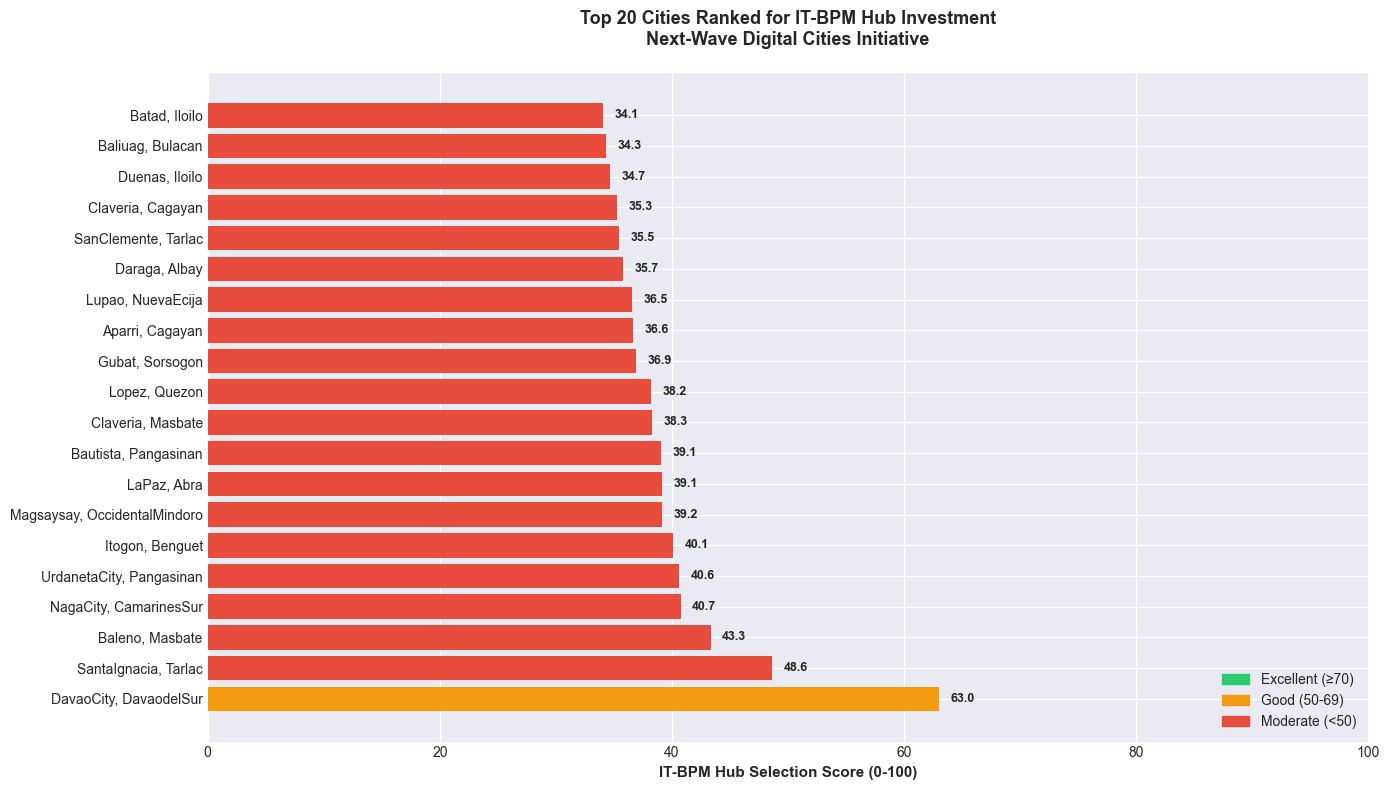

In [69]:
# ============================================================================
# [6.1] CREATE COMPREHENSIVE VISUALIZATIONS FOR STRATEGY PRESENTATION
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Set up visualization style
plt.style.use('seaborn-v0_8-darkgrid')
colors_cluster = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# ============================================================================
# VISUALIZATION 1: IT-BPM HUB SCORES - Bar Chart
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

df_ml_export = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').sort_values(
    by='IT_BPM_Hub_Score_Normalized', ascending=False
)
top_20_cities = df_ml_export.head(20).copy()
colors = ['#2ecc71' if x >= 70 else '#f39c12' if x >= 50 else '#e74c3c' 
          for x in top_20_cities['IT_BPM_Hub_Score_Normalized']]

bars = ax.barh(range(len(top_20_cities)), top_20_cities['IT_BPM_Hub_Score_Normalized'], color=colors)
ax.set_yticks(range(len(top_20_cities)))
ax.set_yticklabels([f"{row['NAME_2']}, {row['NAME_1']}" 
                     for _, row in top_20_cities.iterrows()], fontsize=10)
ax.set_xlabel('IT-BPM Hub Selection Score (0-100)', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Cities Ranked for IT-BPM Hub Investment\nNext-Wave Digital Cities Initiative', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlim(0, 100)

# Add value labels
for i, (idx, row) in enumerate(top_20_cities.iterrows()):
    score = row['IT_BPM_Hub_Score_Normalized']
    ax.text(score + 1, i, f'{score:.1f}', va='center', fontsize=9, fontweight='bold')

# Add legend for color coding
green_patch = mpatches.Patch(color='#2ecc71', label='Excellent (≥70)')
orange_patch = mpatches.Patch(color='#f39c12', label='Good (50-69)')
red_patch = mpatches.Patch(color='#e74c3c', label='Moderate (<50)')
ax.legend(handles=[green_patch, orange_patch, red_patch], loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/01_IT-BPM_Hub_Rankings.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

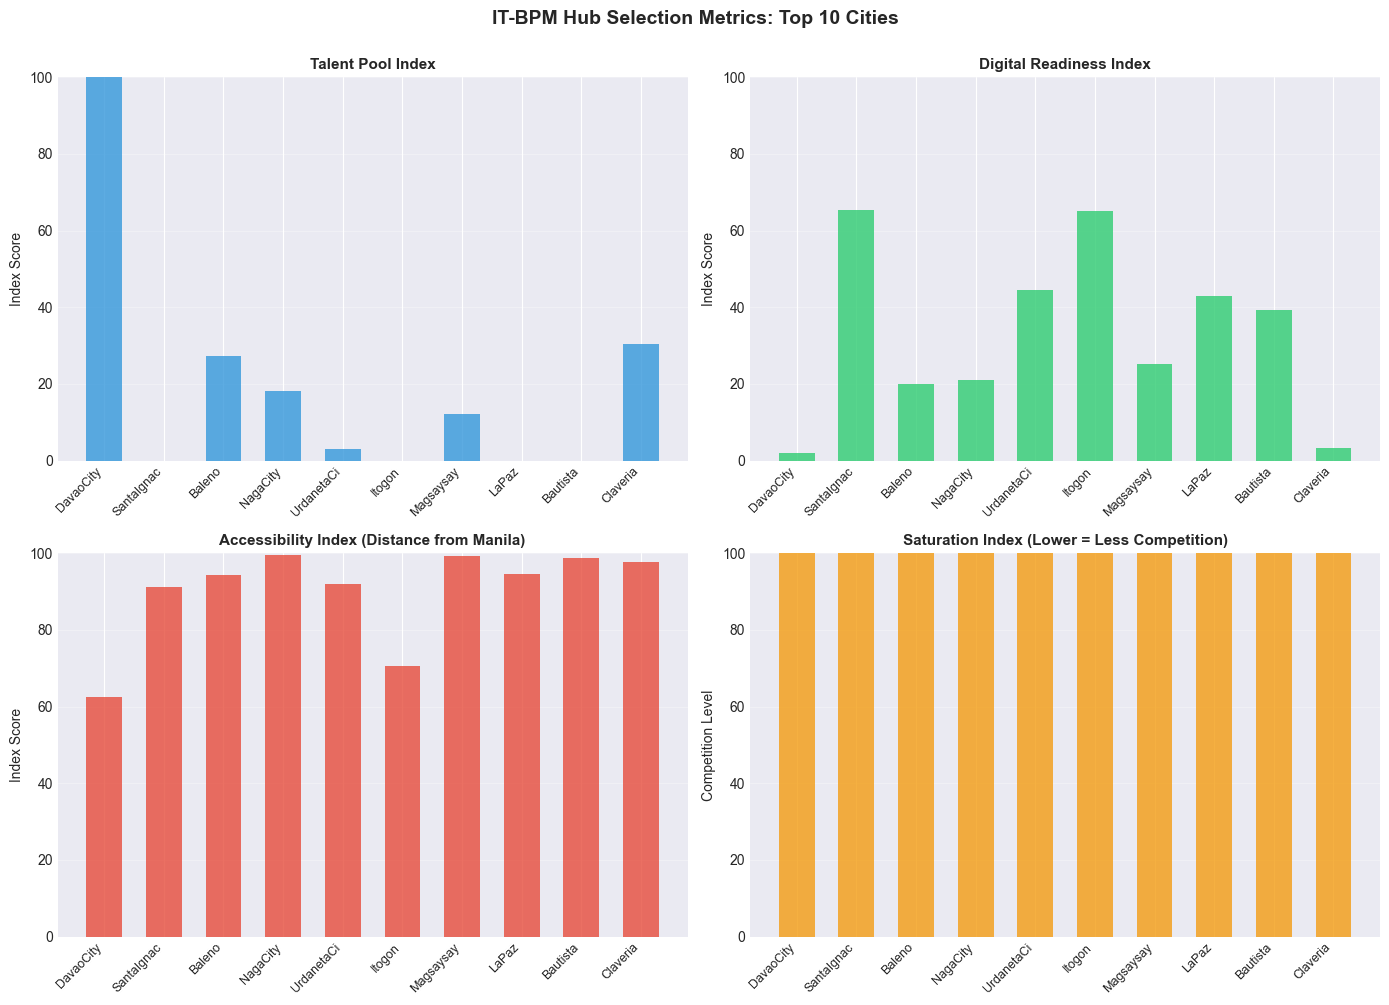

In [70]:
# ============================================================================
# VISUALIZATION 2: Component Scores Comparison (Top 10 Cities)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('IT-BPM Hub Selection Metrics: Top 10 Cities', fontsize=14, fontweight='bold', y=1.00)

top_10 = df_ml_export.head(10)
x_pos = np.arange(len(top_10))
width = 0.2

cities_short = [f"{row['NAME_2'][:10]}" for _, row in top_10.iterrows()]

# Talent Pool Index
ax = axes[0, 0]
ax.bar(x_pos, top_10['Talent_Pool_Index'], width=0.6, color='#3498db', alpha=0.8)
ax.set_ylabel('Index Score', fontsize=10)
ax.set_title('Talent Pool Index', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(cities_short, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Digital Readiness Index
ax = axes[0, 1]
ax.bar(x_pos, top_10['Digital_Readiness_Index'], width=0.6, color='#2ecc71', alpha=0.8)
ax.set_ylabel('Index Score', fontsize=10)
ax.set_title('Digital Readiness Index', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(cities_short, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Accessibility Index
ax = axes[1, 0]
ax.bar(x_pos, top_10['Accessibility_Index'], width=0.6, color='#e74c3c', alpha=0.8)
ax.set_ylabel('Index Score', fontsize=10)
ax.set_title('Accessibility Index (Distance from Manila)', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(cities_short, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Saturation Index (Lower is Better)
ax = axes[1, 1]
ax.bar(x_pos, top_10['Saturation_Index'], width=0.6, color='#f39c12', alpha=0.8)
ax.set_ylabel('Competition Level', fontsize=10)
ax.set_title('Saturation Index (Lower = Less Competition)', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(cities_short, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/02_Component_Scores_Analysis.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

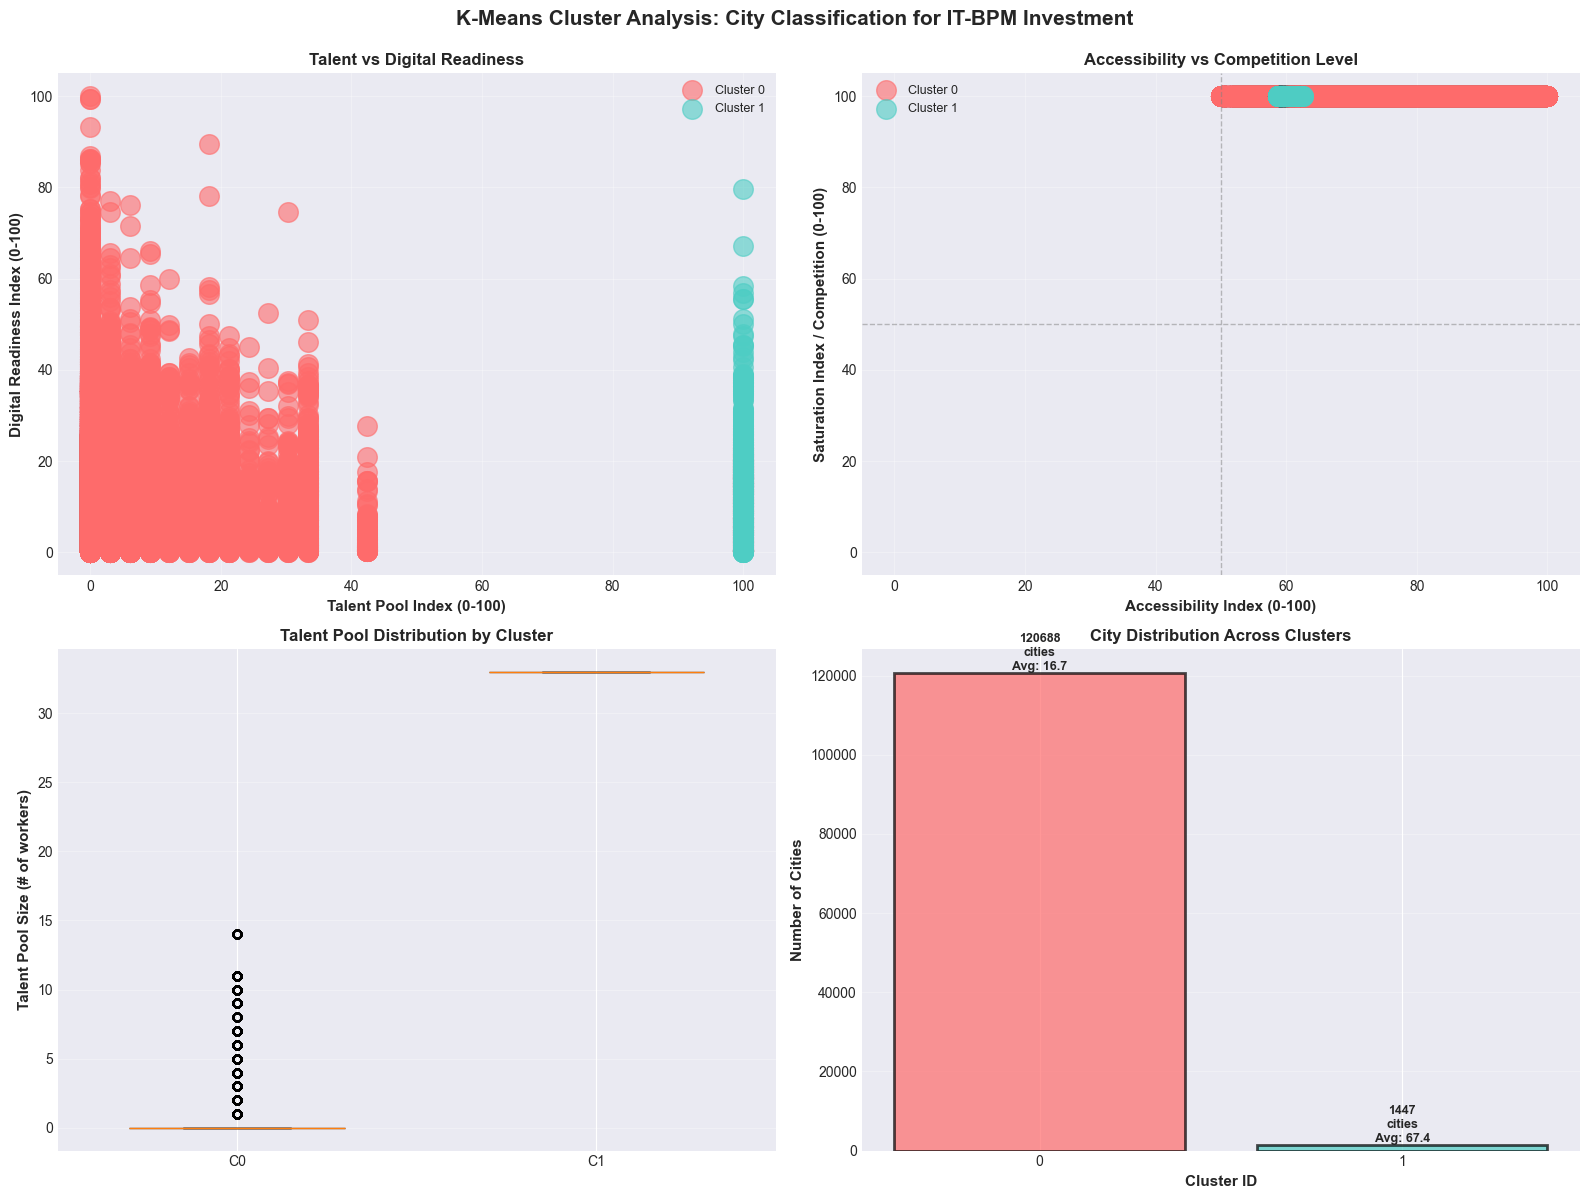

In [71]:
# ============================================================================
# [6.3] K-MEANS CLUSTER VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('K-Means Cluster Analysis: City Classification for IT-BPM Investment', 
             fontsize=15, fontweight='bold', y=0.995)

cluster_colors = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#FFA07A', 4: '#98D8C8'}

# Plot 1: Talent vs Digital Readiness (colored by cluster)
ax = axes[0, 0]
for cluster_id in range(optimal_k):
    cluster_data = df_ml[df_ml['Cluster'] == cluster_id]
    ax.scatter(cluster_data['Talent_Pool_Index'], 
               cluster_data['Digital_Readiness_Index'],
               s=200, alpha=0.6, label=f'Cluster {cluster_id}',
               color=cluster_colors.get(cluster_id, '#999999'))

ax.set_xlabel('Talent Pool Index (0-100)', fontsize=11, fontweight='bold')
ax.set_ylabel('Digital Readiness Index (0-100)', fontsize=11, fontweight='bold')
ax.set_title('Talent vs Digital Readiness', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

# Plot 2: Accessibility vs Saturation (colored by cluster)
ax = axes[0, 1]
for cluster_id in range(optimal_k):
    cluster_data = df_ml[df_ml['Cluster'] == cluster_id]
    ax.scatter(cluster_data['Accessibility_Index'], 
               cluster_data['Saturation_Index'],
               s=200, alpha=0.6, label=f'Cluster {cluster_id}',
               color=cluster_colors.get(cluster_id, '#999999'))

ax.set_xlabel('Accessibility Index (0-100)', fontsize=11, fontweight='bold')
ax.set_ylabel('Saturation Index / Competition (0-100)', fontsize=11, fontweight='bold')
ax.set_title('Accessibility vs Competition Level', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

# Add quadrant lines for "sweet spot" identification
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Plot 3: Talent Pool Size by Cluster (Box plot)
ax = axes[1, 0]
cluster_talent_data = [df_ml[df_ml['Cluster'] == i]['Talent_Pool_Size'].values 
                       for i in range(optimal_k)]
bp = ax.boxplot(cluster_talent_data, labels=[f'C{i}' for i in range(optimal_k)],
                patch_artist=True, widths=0.6)

for patch, cluster_id in zip(bp['boxes'], range(optimal_k)):
    patch.set_facecolor(cluster_colors.get(cluster_id, '#999999'))
    patch.set_alpha(0.7)

ax.set_ylabel('Talent Pool Size (# of workers)', fontsize=11, fontweight='bold')
ax.set_title('Talent Pool Distribution by Cluster', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Number of cities in each cluster
ax = axes[1, 1]
cluster_counts = [len(df_ml[df_ml['Cluster'] == i]) for i in range(optimal_k)]
cluster_avg_scores = [df_ml[df_ml['Cluster'] == i]['IT_BPM_Hub_Score_Normalized'].mean() 
                     for i in range(optimal_k)]

bars = ax.bar(range(optimal_k), cluster_counts, 
              color=[cluster_colors.get(i, '#999999') for i in range(optimal_k)],
              alpha=0.7, edgecolor='black', linewidth=2)

# Add count labels on bars
for i, (bar, count, score) in enumerate(zip(bars, cluster_counts, cluster_avg_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}\ncities\nAvg: {score:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Cities', fontsize=11, fontweight='bold')
ax.set_title('City Distribution Across Clusters', fontsize=12, fontweight='bold')
ax.set_xticks(range(optimal_k))
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('Exploratory Data Analysis (EDA)/03_K-Means_Cluster_Analysis.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

## **Geospatial Visualization - Interactive Map**
Create an interactive **Folium map** to visualize the preprocessed geospatial dataset with employment clusters and digital readiness metrics.

In [72]:
# ============================================================================
# INTERACTIVE FOLIUM CHOROPLETH MAP - AGGREGATED GEOSPATIAL VISUALIZATION
# ============================================================================

import folium
from folium import plugins
import json
import geopandas as gpd
import pandas as pd
import numpy as np

# Load the preprocessed GeoJSON dataset
geojson_path = 'PreprocessedDataset_Encallado.geojson'

try:
    # Load GeoJSON data
    gdf_map = gpd.read_file(geojson_path)
    
    print(f"✓ GeoJSON file loaded: {len(gdf_map)} features")
    print(f"  Aggregating by municipality for better visualization...")
    
    # Aggregate data by municipality to reduce marker count
    gdf_agg = gdf_map.groupby(['NAME_2', 'NAME_1']).agg({
        'tests': 'sum',
        'devices': 'sum',
        'avg_d_kbps': 'mean',
        'avg_u_kbps': 'mean',
        'avg_lat_ms': 'mean',
        'Population_2024': 'first',
        'Distance_from_Metro Manila_km': 'first',
        'No_Work_Count': 'first',
        'geometry': 'first'
    }).reset_index()
    
    print(f"  ✓ Aggregated into {len(gdf_agg)} municipalities for visualization")
    
    # ============================================================================
    # LOAD GADM POLYGONS FOR CHOROPLETH
    # ============================================================================
    # Load the GADM Philippines municipality boundaries
    ph = gpd.read_file('gadm41_PHL_2.json')
    
    # Merge aggregated data with GADM polygons
    gdf_choropleth = ph.merge(
        gdf_agg[['NAME_2', 'NAME_1', 'tests', 'devices', 'avg_d_kbps', 'avg_u_kbps', 
                 'avg_lat_ms', 'Population_2024', 'Distance_from_Metro Manila_km', 'No_Work_Count']],
        on=['NAME_2', 'NAME_1'],
        how='left'
    )
    
    # Fill NaN values with 0 for municipalities without data
    gdf_choropleth['avg_d_kbps'] = gdf_choropleth['avg_d_kbps'].fillna(0)
    gdf_choropleth['avg_u_kbps'] = gdf_choropleth['avg_u_kbps'].fillna(0)
    gdf_choropleth['avg_lat_ms'] = gdf_choropleth['avg_lat_ms'].fillna(0)
    gdf_choropleth['tests'] = gdf_choropleth['tests'].fillna(0)
    gdf_choropleth['devices'] = gdf_choropleth['devices'].fillna(0)
    
    print(f"  ✓ Merged with GADM boundaries: {len(gdf_choropleth)} municipalities")
    
    # ============================================================================
    # GET TOP 20 IT-BPM HUBS FROM df_ml (if available)
    # ============================================================================
    try:
        top_20 = df_ml.drop_duplicates(subset=['NAME_2', 'NAME_1'], keep='first').nlargest(20, 'IT_BPM_Hub_Score_Normalized')[
            ['NAME_2', 'NAME_1', 'Talent_Pool_Size', 'Avg_Internet_Speed_Mbps', 
             'Distance_from_Metro Manila_km', 'Population_2024', 'IT_BPM_Hub_Score_Normalized']
        ].reset_index(drop=True)
        
        # Add rank column
        top_20['Rank'] = range(1, len(top_20) + 1)
        
        print(f"  ✓ Identified Top 20 IT-BPM Hub locations")
        print(f"    Top 5: {', '.join(top_20.head(5)['NAME_2'].tolist())}")
    except (NameError, KeyError) as e:
        print(f"  [!] Could not load Top 20 hubs (df_ml not available or missing columns). Map will show without hub highlights.")
        top_20 = pd.DataFrame()  # Empty dataframe
    
    # Create a set for quick lookup
    top_20_locations = set(zip(top_20['NAME_2'], top_20['NAME_1'])) if len(top_20) > 0 else set()
    top_5_locations = set(zip(top_20.head(5)['NAME_2'], top_20.head(5)['NAME_1'])) if len(top_20) > 0 else set()
    
    # Create dictionary for quick hub score lookup
    if len(top_20) > 0:
        hub_score_dict = dict(zip(zip(top_20['NAME_2'], top_20['NAME_1']), 
                                   zip(top_20['IT_BPM_Hub_Score_Normalized'], 
                                       top_20['Rank'],
                                       top_20['Talent_Pool_Size'],
                                       top_20['Avg_Internet_Speed_Mbps'])))
    else:
        hub_score_dict = {}
    
    # Calculate center of the map
    bounds = gdf_map.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create base Folium map with multiple tile options
    # Zoom level 6 to show entire Philippines
    map_folium = folium.Map(
        location=[12.8797, 121.7740],  # Center of Philippines
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='CartoDB Positron',
        overlay=False,
        control=True
    ).add_to(map_folium)
    
    # ADD SEARCH BAR (by Municipality Name)
    from folium.plugins import Search

    # Build simple GeoJSON with name + geometry only
    search_features = []

    for idx, row in gdf_choropleth.iterrows():
        geom = row["geometry"].__geo_interface__
        mun = row["NAME_2"]
        prov = row["NAME_1"]

        search_features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "name": f"{mun}, {prov}"
            }
        })

    search_geojson = {
        "type": "FeatureCollection",
        "features": search_features
    }

    # Create GeoJson layer
    gj_search = folium.GeoJson(
        search_geojson,
        name="Search Layer",
        show=True,   # don't display polygons if not needed
        tooltip=folium.GeoJsonTooltip(fields=["name"], labels=False)
    ).add_to(map_folium)

    # Add the search bar widget
    Search(
        layer=gj_search,
        geom_type='Polygon',
        placeholder="Search places...",
        collapsed=False,                # expanded by default
        search_label='name',            # property to match
        position='topright',             # top-right corner
        zoom=9,                         # zoom level when found
    ).add_to(map_folium)

    # Add title with enhanced styling
    title_html = '''
    <div style="position: fixed; 
                top: 15px; left: 15px; width: 420px; height: 100px; 
                background-color: rgba(255, 255, 255, 0.98); border:3px solid #2c5f2d; z-index:9999; 
                font-size: 15px; font-weight: bold; padding: 15px;
                border-radius: 10px; box-shadow: 0 6px 12px rgba(0,0,0,0.25); user-select: none;">
    <span style="color: #006400; font-size: 19px; font-family: 'Arial Black', sans-serif;">Philippines IT-BPM Hub Analysis</span>
    <br><small style="color: #555; font-size: 13px; font-weight: normal;">Digital Readiness & Connectivity Metrics Dashboard (Beta)</small>
    <br><small style="color: #888; margin-top: 6px; font-size: 12px; font-weight: normal;">💡 <b><i>Tip:</i></b> Hover for details | Click markers for comprehensive info</small>
    </div>
    '''
    map_folium.get_root().html.add_child(folium.Element(title_html))
    
    # Define color function for choropleth - BASED ON DOWNLOAD SPEED ONLY
    def get_color(avg_download_speed, municipality, province):
        """Color based on download speed (connectivity quality)"""
        # Color scheme based ONLY on download speed for all locations
        if pd.isna(avg_download_speed) or avg_download_speed == 0:
            return '#E0E0E0'  # Light gray for missing data
        if avg_download_speed >= 50000:  # >= 50 Mbps
            return '#006400'  # Dark green - Excellent
        elif avg_download_speed >= 25000:  # >= 25 Mbps
            return '#228B22'  # Forest green - Good
        elif avg_download_speed >= 10000:  # >= 10 Mbps
            return '#FFD700'  # Gold - Moderate
        elif avg_download_speed >= 5000:  # >= 5 Mbps
            return '#FF8C00'  # Dark orange - Fair
        else:
            return '#FF0000'  # Red - Poor
    
    def get_star_color(municipality, province):
        """Get star color for Top 20 IT-BPM hubs"""
        location_key = (municipality, province)
        if location_key in top_5_locations:
            return '#8B008B'  # Purple for Top 5
        elif location_key in top_20_locations:
            return '#FF1493'  # Barbie Pink for Top 6-20
        return None  # Not a hub
    
    def get_radius(test_count, municipality, province):
        """Scale radius - larger for top IT-BPM hubs"""
        location_key = (municipality, province)
        
        # Larger markers for top hubs
        if location_key in top_5_locations:
            return 18  # Largest for Top 5
        elif location_key in top_20_locations:
            return 14  # Large for Top 6-20
        
        # Regular size for non-hub locations
        if pd.isna(test_count) or test_count == 0:
            return 4
        return min(20, max(3, np.log10(max(1, test_count)) * 3))
    
    # Add color column to GeoDataFrame for choropleth
    gdf_choropleth['color'] = gdf_choropleth.apply(
        lambda row: get_color(row['avg_d_kbps'], row['NAME_2'], row['NAME_1']),
        axis=1
    )
    
    # Create a custom style function for choropleth - ALL BASED ON DOWNLOAD SPEED
    def style_function(feature):
        municipality = feature['properties']['NAME_2']
        province = feature['properties']['NAME_1']
        avg_d_kbps = feature['properties'].get('avg_d_kbps', 0)
        
        color = get_color(avg_d_kbps, municipality, province)
        
        return {
            'fillColor': color,
            'color': '#333333',  # Border color
            'weight': 1,
            'fillOpacity': 0.7
        }
    
    # Create highlight function for hover effect
    def highlight_function(feature):
        municipality = feature['properties']['NAME_2']
        province = feature['properties']['NAME_1']
        avg_d_kbps = feature['properties'].get('avg_d_kbps', 0)
        
        color = get_color(avg_d_kbps, municipality, province)
        
        return {
            'fillColor': color,
            'color': '#000000',
            'weight': 3,
            'fillOpacity': 0.9
        }
    
    # Add choropleth layer with popups
    # Create GeoJson layer with popup functionality
    for idx, row in gdf_choropleth.iterrows():
        municipality = row['NAME_2']
        province = row['NAME_1']
        location_key = (municipality, province)
        
        # Skip if no test data
        if row['tests'] == 0:
            continue
        
        # Get metrics
        test_count = row['tests']
        device_count = row['devices']
        download_speed = row['avg_d_kbps'] / 1000  # Convert to Mbps
        
        # Check if this is a top IT-BPM hub
        is_top_hub = location_key in top_20_locations
        
        # Create detailed popup with all metrics
        popup_html = f"""
        <div style="font-family: Arial; width: 320px; max-height: 450px; overflow-y: auto; user-select: none;">
            <h4 style="margin: 5px 0 10px 0; color: #006400; border-bottom: 2px solid #006400; padding-bottom: 5px;">
            📍 {municipality}
            </h4>
        """
        
        # Add IT-BPM Hub information if applicable
        if is_top_hub:
            hub_score, rank, talent_pool, avg_speed = hub_score_dict[location_key]
            badge_color = "#8B008B" if location_key in top_5_locations else "#FF1493"
            badge_text = '★ TOP 5 IT-BPM HUB' if location_key in top_5_locations else '★ TOP 20 IT-BPM HUB'
            popup_html += f"""
            <div style="background-color: {badge_color}; color: white; padding: 10px; border-radius: 6px; margin-bottom: 10px; text-align: center;">
                <b style="font-size: 14px;">{badge_text}</b>
                <div style="font-size: 18px; font-weight: bold; margin-top: 5px;">Rank #{rank}</div>
            </div>
            
            <div style="background-color: #fff3cd; padding: 8px; border-radius: 4px; margin-bottom: 8px; border-left: 4px solid #ffc107;">
                <b style="font-size: 12px; color: #856404;">IT-BPM Hub Metrics:</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Hub Score:</b></td>
                        <td><span style="color: #d63384; font-weight: bold;">{hub_score:.4f}</span></td>
                    </tr>
                </table>
            </div>
            """
        
        popup_html += f"""
            <div style="background-color: #f9f9f9; padding: 8px; border-radius: 4px; margin-bottom: 8px;">
                <b style="font-size: 12px;">Location Info:</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Province:</b></td>
                        <td>{province}</td>
                    </tr>
                    <tr>
                        <td><b>Population:</b></td>
                        <td>{int(row['Population_2024']) if pd.notna(row['Population_2024']) else 'N/A'}</td>
                    </tr>
                    <tr>
                        <td><b>No Work Count (LFS-PUF-October-2024):</b></td>
                        <td>{int(row['No_Work_Count']) if pd.notna(row['No_Work_Count']) & int(row['No_Work_Count']) != 0 else 'N/A'}</td>
                    </tr>
                    <tr>
                        <td><b>Distance to Manila:</b></td>
                        <td>{row['Distance_from_Metro Manila_km']:.1f} {'km' if pd.notna(row['Distance_from_Metro Manila_km']) else 'N/A'}</td>
                    </tr>
                </table>
            </div>
            
            <div style="background-color: #f0f8ff; padding: 8px; border-radius: 4px; margin-bottom: 8px;">
                <b style="font-size: 12px;">Connectivity Metrics:</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Download Speed:</b></td>
                        <td>{download_speed:.2f} Mbps</td>
                    </tr>
                    <tr>
                        <td><b>Upload Speed:</b></td>
                        <td>{row['avg_u_kbps']/1000:.2f} Mbps</td>
                    </tr>
                    <tr>
                        <td><b>Latency:</b></td>
                        <td>{row['avg_lat_ms']:.1f} ms</td>
                    </tr>
                </table>
            </div>
            
            <div style="background-color: #fffacd; padding: 8px; border-radius: 4px;">
                <b style="font-size: 12px;">Data Coverage (Pixel Metrics):</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Test Count:</b></td>
                        <td>{int(test_count):,} tests</td>
                    </tr>
                    <tr>
                        <td><b>Device Count:</b></td>
                        <td>{int(device_count):,} devices</td>
                    </tr>
                    <tr>
                        <td><b>Avg Tests/Device:</b></td>
                        <td>{test_count/max(1, device_count):.1f}</td>
                    </tr>
                </table>
            </div>
        </div>
        """
        
        # Add the polygon geometry with popup
        geom_json = row['geometry'].__geo_interface__
        
        folium.GeoJson(
            geom_json,
            style_function=lambda x, color=get_color(row['avg_d_kbps'], municipality, province): {
                'fillColor': color,
                'color': '#333333',
                'weight': 1,
                'fillOpacity': 0.7
            },
            highlight_function=lambda x, color=get_color(row['avg_d_kbps'], municipality, province): {
                'fillColor': color,
                'color': '#000000',
                'weight': 3,
                'fillOpacity': 0.9
            },
            popup=folium.Popup(popup_html, max_width=340),
            tooltip=folium.Tooltip(
                f"<b>{municipality}, {province}</b><br>Tests: {int(test_count):,}",
                sticky=True
            )
        ).add_to(map_folium)
    
    # ============================================================================
    # ADD STAR MARKERS FOR TOP 20 IT-BPM HUBS (OVERLAY ON CHOROPLETH) - ALSO CLICKABLE
    # ============================================================================
    for idx, row in gdf_choropleth.iterrows():
        municipality = row['NAME_2']
        province = row['NAME_1']
        location_key = (municipality, province)
        
        # Only add star markers for Top 20 hubs
        if location_key not in top_20_locations:
            continue
            
        # Skip if no test data
        if row['tests'] == 0:
            continue
        
        # Get metrics
        test_count = row['tests']
        device_count = row['devices']
        radius = get_radius(test_count, municipality, province)
        star_color = get_star_color(municipality, province)
        
        # Get centroid for star marker
        geom = row['geometry']
        if geom.geom_type == 'Point':
            lat, lon = geom.y, geom.x
        elif geom.geom_type in ['Polygon', 'MultiPolygon']:
            centroid = geom.centroid
            lat, lon = centroid.y, centroid.x
        else:
            continue
        
        download_speed = row['avg_d_kbps'] / 1000  # Convert to Mbps
        
        # Get hub information
        hub_score, rank, talent_pool, avg_speed = hub_score_dict[location_key]
        hub_badge = "★ TOP 5" if location_key in top_5_locations else "★ TOP 20"
        
        tooltip_text = f"""
        <b style="font-size: 13px; color: {star_color};">
        {hub_badge} - #{rank} IT-BPM Hub
        </b><br>
        <b style="font-size: 12px; color: #333;">
        {municipality}, {province}
        </b><br>
        Hub Score: {hub_score:.3f} | Tests: {int(test_count):,}
        """
        
        # Create detailed popup with all metrics (SAME AS CHOROPLETH POPUP)
        popup_html = f"""
        <div style="font-family: Arial; width: 320px; max-height: 450px; overflow-y: auto; user-select: none;">
            <h4 style="margin: 5px 0 10px 0; color: #006400; border-bottom: 2px solid #006400; padding-bottom: 5px;">
            📍 {municipality}
            </h4>
            <div style="background-color: {star_color}; color: white; padding: 10px; border-radius: 6px; margin-bottom: 10px; text-align: center;">
                <b style="font-size: 14px;">{hub_badge} IT-BPM HUB</b>
                <div style="font-size: 18px; font-weight: bold; margin-top: 5px;">Rank #{rank}</div>
            </div>
            
            <div style="background-color: #fff3cd; padding: 8px; border-radius: 4px; margin-bottom: 8px; border-left: 4px solid #ffc107;">
                <b style="font-size: 12px; color: #856404;">IT-BPM Hub Metrics:</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Hub Score:</b></td>
                        <td><span style="color: #d63384; font-weight: bold;">{hub_score:.4f}</span></td>
                    </tr>
                </table>
            </div>
            <div style="background-color: #f9f9f9; padding: 8px; border-radius: 4px; margin-bottom: 8px;">
                <b style="font-size: 12px;">Location Info:</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Province:</b></td>
                        <td>{province}</td>
                    </tr>
                    <tr>
                        <td><b>Population:</b></td>
                        <td>{int(row['Population_2024']) if pd.notna(row['Population_2024']) else 'N/A'}</td>
                    </tr>
                    <tr>
                        <td><b>No Work Count (LFS-PUF-October-2024):</b></td>
                        <td>{int(row['No_Work_Count']) if pd.notna(row['No_Work_Count']) & int(row['No_Work_Count']) != 0 else 'N/A'}</td>
                    </tr>
                    <tr>
                        <td><b>Distance to Manila:</b></td>
                        <td>{row['Distance_from_Metro Manila_km']:.1f} {'km' if pd.notna(row['Distance_from_Metro Manila_km']) else 'N/A'}</td>
                    </tr>
                </table>
            </div>
            
            <div style="background-color: #f0f8ff; padding: 8px; border-radius: 4px; margin-bottom: 8px;">
                <b style="font-size: 12px;">Connectivity Metrics:</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Download Speed:</b></td>
                        <td>{download_speed:.2f} Mbps</td>
                    </tr>
                    <tr>
                        <td><b>Upload Speed:</b></td>
                        <td>{row['avg_u_kbps']/1000:.2f} Mbps</td>
                    </tr>
                    <tr>
                        <td><b>Latency:</b></td>
                        <td>{row['avg_lat_ms']:.1f} ms</td>
                    </tr>
                </table>
            </div>
            
            <div style="background-color: #fffacd; padding: 8px; border-radius: 4px;">
                <b style="font-size: 12px;">Data Coverage (Pixel Metrics):</b>
                <table style="width: 100%; font-size: 11px; margin-top: 5px;">
                    <tr>
                        <td><b>Test Count:</b></td>
                        <td>{int(test_count):,} tests</td>
                    </tr>
                    <tr>
                        <td><b>Device Count:</b></td>
                        <td>{int(device_count):,} devices</td>
                    </tr>
                    <tr>
                        <td><b>Avg Tests/Device:</b></td>
                        <td>{test_count/max(1, device_count):.1f}</td>
                    </tr>
                </table>
            </div>
        </div>
        """
        
        # Add star marker WITH popup (clickable)
        icon_html = f'''
        <div style="font-size: {radius*1.5}px; color: {star_color}; 
                    text-shadow: 0 0 3px rgba(0,0,0,0.5), 0 0 5px {star_color};
                    transform: translate(-50%, -50%);">★</div>
        '''
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(html=icon_html),
            popup=folium.Popup(popup_html, max_width=340),
            tooltip=folium.Tooltip(tooltip_text, sticky=True)
        ).add_to(map_folium)
    
    # Add TOP 20 IT-BPM HUBS LEGEND (Left-Bottom) with STAR SHAPES
    top20_legend_html = f'''
    <div style="position: fixed; 
                bottom: 15px; left: 15px; width: 300px; max-height: 500px; overflow-y: auto;
                background-color: rgba(255, 255, 255, 0.98); border:3px solid #2c5f2d; z-index:9999; 
                font-size: 12px; padding: 15px; border-radius: 10px; box-shadow: 0 6px 12px rgba(0,0,0,0.25); 
                user-select: none; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    
    <b style="font-size: 15px; display: block; margin-bottom: 12px; color: #2c5f2d; border-bottom: 2px solid #8B008B; padding-bottom: 8px;">
    Top 20 IT-BPM Hubs <span style="color: #666; font-size: 10px;">(outside Metro Manila)</span>
    </b>
    
    <div style="margin-bottom: 12px; padding: 10px; background: linear-gradient(135deg, #f5e6ff 0%, #fce4ff 100%); 
                border-radius: 6px; border-left: 5px solid #8B008B;">
        <b style="font-size: 12px; color: #6b1f6b; display: block; margin-bottom: 6px;">Hub Color Coding:</b>
        <div style="margin-top: 8px; font-size: 11px; line-height: 1.8;">
            <span style="display: inline-block; margin-right: 8px; vertical-align: middle; font-size: 18px; color: #8B008B;">★</span> 
            <b style="color: #333;">Top 5 Elite Hubs</b><br>
            <span style="display: inline-block; margin-right: 8px; vertical-align: middle; font-size: 18px; color: #FF1493;">★</span> 
            <b style="color: #333;">Top 6-20 Premier Hubs</b>
        </div>
    </div>
    
    <div style="margin-bottom: 12px; padding: 10px; background-color: #f8fbff; border-radius: 6px; 
                max-height: 200px; overflow-y: auto; border: 2px solid #e3f2fd;">
        <b style="font-size: 12px; color: #1565c0; display: block; margin-bottom: 8px;">Ranked by IT-BPM Hub Score:</b>
        <div style="margin-top: 8px; font-size: 11px; line-height: 1.8;">
    '''
    
    # Add top 20 list to legend with star shapes
    for _, hub in top_20.iterrows():
        rank = hub['Rank']
        star_color = '#8B008B' if rank <= 5 else '#FF1493'  # Purple for Top 5, Barbie Pink for 6-20
        bg_color = 'rgba(139, 0, 139, 0.1)' if rank <= 5 else 'rgba(255, 20, 147, 0.1)'
        border_color = '#8B008B' if rank <= 5 else '#FF1493'
        
        top20_legend_html += f'''
            <div style="margin: 4px 0; padding: 6px 8px; background: {bg_color}; border-radius: 4px; 
                        border-left: 4px solid {border_color}; display: flex; align-items: center;">
                <span style="display: inline-block; margin-right: 8px; flex-shrink: 0; font-size: 14px; color: {star_color};">★</span>
                <div style="flex-grow: 1;">
                    <b style="color: #1a1a1a; font-size: 11px;">#{rank}</b> 
                    <span style="color: #333; font-weight: 600;">{hub['NAME_2']}</span>, 
                    <span style="color: #666;">{hub['NAME_1']}</span>
                    <br>
                    <span style="color: #0066cc; font-size: 10px;">Score: {hub['IT_BPM_Hub_Score_Normalized']:.4f}</span>
                </div>
            </div>
        '''
    
    top20_legend_html += '''
        </div>
    </div>
    
    <div style="font-size: 10px; color: #555; line-height: 1.5; font-style: italic; 
                background-color: #fffbea; padding: 8px; border-radius: 4px; border-left: 3px solid #fbbf24;">
        💡 <b>Tip:</b> Click on purple/pink star markers for detailed hub analytics and metrics
    </div>
    </div>
    '''
    map_folium.get_root().html.add_child(folium.Element(top20_legend_html))
    
    # Add ORIGINAL LEGEND (Right-Bottom)
    original_legend_html = '''
    <div style="position: fixed; 
                bottom: 15px; right: 15px; width: 320px; 
                background-color: rgba(255, 255, 255, 0.98); border:3px solid #2c5f2d; z-index:9999; 
                font-size: 12px; padding: 15px; border-radius: 10px; box-shadow: 0 6px 12px rgba(0,0,0,0.25); 
                user-select: none; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    
    <b style="font-size: 15px; display: block; margin-bottom: 12px; color: #2c5f2d; border-bottom: 2px solid #4169E1; padding-bottom: 8px;">
    Legend & Metrics
    </b>
    
    <div style="margin-bottom: 12px; padding: 10px; border-bottom: 2px solid #e0e0e0; background: linear-gradient(135deg, #f0f9ff 0%, #f8fbff 100%); border-radius: 6px;">
        <b style="font-size: 12px; color: #1565c0; display: block; margin-bottom: 8px;">Download Speed (Connectivity Quality):</b>
        <div style="margin-top: 8px; font-size: 11px; line-height: 1.9;">
            <div style="margin-bottom: 3px;">
                <span style="display: inline-block; width: 20px; height: 14px; background: #006400; border-radius: 3px; margin-right: 8px; border: 1px solid #004d00;"></span> 
                <span style="color: #333;"><b>≥50 Mbps</b> - Excellent</span>
            </div>
            <div style="margin-bottom: 3px;">
                <span style="display: inline-block; width: 20px; height: 14px; background: #228B22; border-radius: 3px; margin-right: 8px; border: 1px solid #1a6b1a;"></span> 
                <span style="color: #333;"><b>25-50 Mbps</b> - Good</span>
            </div>
            <div style="margin-bottom: 3px;">
                <span style="display: inline-block; width: 20px; height: 14px; background: #FFD700; border-radius: 3px; margin-right: 8px; border: 1px solid #daa520;"></span> 
                <span style="color: #333;"><b>10-25 Mbps</b> - Moderate</span>
            </div>
            <div style="margin-bottom: 3px;">
                <span style="display: inline-block; width: 20px; height: 14px; background: #FF8C00; border-radius: 3px; margin-right: 8px; border: 1px solid #d97000;"></span> 
                <span style="color: #333;"><b>5-10 Mbps</b> - Fair</span>
            </div>
            <div style="margin-bottom: 3px;">
                <span style="display: inline-block; width: 20px; height: 14px; background: #FF0000; border-radius: 3px; margin-right: 8px; border: 1px solid #cc0000;"></span> 
                <span style="color: #333;"><b>&lt;5 Mbps</b> - Poor</span>
            </div>
            <div>
                <span style="display: inline-block; width: 20px; height: 14px; background: #E0E0E0; border-radius: 3px; margin-right: 8px; border: 1px solid #999;"></span> 
                <span style="color: #333;"><b>No Data</b></span>
            </div>
        </div>
    </div>
    
    <div style="margin-bottom: 12px; padding: 10px; border-bottom: 2px solid #e0e0e0; background: linear-gradient(135deg, #fef3f3 0%, #fff8f8 100%); border-radius: 6px;">
        <b style="font-size: 12px; color: #c23b2a; display: block; margin-bottom: 8px;">Choropleth Regions:</b>
        <div style="margin-top: 8px; font-size: 11px; line-height: 1.8; color: #333;">
            All places are color-coded by connectivity quality. Hover over regions for quick info, click for detailed metrics.
        </div>
    </div>
    
    <div style="font-size: 10px; color: #555; line-height: 1.6; background-color: #f0fdf4; padding: 10px; border-radius: 6px; border-left: 3px solid #10b981;">
        <b style="color: #047857; display: block; margin-bottom: 4px;">How to Use:</b>
        <div style="color: #333;">
        ✓ <b>Hover</b> over regions for quick info<br>
        ✓ <b>Click</b> markers/regions for details<br>
        ✓ Use <b>layer switcher</b> for map styles<br>
        ✓ Data aggregated by municipality
        </div>
    </div>
    </div>
    '''
    map_folium.get_root().html.add_child(folium.Element(original_legend_html))
    
    # Add fullscreen button
    plugins.Fullscreen(position='topright').add_to(map_folium)
    
    # Add layer control for tile switching
    folium.LayerControl(position='topright').add_to(map_folium)
    
    # Save the map
    map_output_path = 'InteractiveFoliumMap_Encallado.html'
    map_folium.save(map_output_path)
    print(f"\n✓ Interactive choropleth map saved as: {map_output_path}")
    print(f"\tTotal GPS tiles in dataset: {len(gdf_map):,}")
    print(f"\tAggregated to municipalities: {len(gdf_agg)}")
    print(f"\tChoropleth regions: {len(gdf_choropleth)}")
    print(f"\tTop 20 IT-BPM Hubs highlighted with star markers")
    print(f"\tMap covers area: {bounds[1]:.2f}°S to {bounds[3]:.2f}°N, {bounds[0]:.2f}°E to {bounds[2]:.2f}°E")
    print(f"\tOpen the HTML file in a web browser to explore interactively")
    print(f"\tFeatures: Hover for tooltips | Click for details | Layer switcher & Fullscreen available")
    
    # Display the map
    map_folium
    
except FileNotFoundError as e:
    print(f"[!] File not found: {str(e)}")
    print("  Please ensure the preprocessing step has been executed and GADM file exists.")
except Exception as e:
    print(f"[!] Error creating map: {str(e)}")
    import traceback
    traceback.print_exc()

✓ GeoJSON file loaded: 122135 features
  Aggregating by municipality for better visualization...
  ✓ Aggregated into 1643 municipalities for visualization
  ✓ Merged with GADM boundaries: 1647 municipalities
  ✓ Identified Top 20 IT-BPM Hub locations
    Top 5: DavaoCity, SantaIgnacia, Baleno, NagaCity, UrdanetaCity
  ✓ Merged with GADM boundaries: 1647 municipalities
  ✓ Identified Top 20 IT-BPM Hub locations
    Top 5: DavaoCity, SantaIgnacia, Baleno, NagaCity, UrdanetaCity

✓ Interactive choropleth map saved as: InteractiveFoliumMap_Encallado.html
	Total GPS tiles in dataset: 122,135
	Aggregated to municipalities: 1643
	Choropleth regions: 1647
	Top 20 IT-BPM Hubs highlighted with star markers
	Map covers area: 4.65°S to 20.79°N, 116.97°E to 126.60°E
	Open the HTML file in a web browser to explore interactively
	Features: Hover for tooltips | Click for details | Layer switcher & Fullscreen available

✓ Interactive choropleth map saved as: InteractiveFoliumMap_Encallado.html
	Total G

# **Section 7: Executive Summary & Strategic Recommendations**

**Comprehensive findings, key insights, and policy recommendations** based on machine learning analysis.

In [73]:
# ============================================================================
# [7.1] EXECUTIVE SUMMARY - KEY FINDINGS & METRICS
# ============================================================================

print("\n" + "="*80)
print("EXECUTIVE SUMMARY: IT-BPM HUB STRATEGIC ANALYSIS")
print("="*80)

print("\nANALYSIS OVERVIEW")
print("─" * 80)
print(f"Total Municipalities Analyzed: {len(df_ml)}")
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")
print(f"Data Sources Integrated:")
print(f"  • Labor Force Survey (LFS) - Talent availability")
print(f"  • Internet Speed Data (Ookla proxy) - Digital infrastructure")
print(f"  • Geographic Data (OSM/GADM) - Accessibility & amenities")
print(f"  • Population Census - Market size")

print("\n" + "="*80)
print("TOP 5 RECOMMENDED CITIES FOR IT-BPM HUB INVESTMENT")
print("="*80)

df_ml_export = (
    df_ml
    .drop_duplicates(subset=['NAME_1', 'NAME_2'], keep='first')
    .sort_values(by='IT_BPM_Hub_Score_Normalized', ascending=False)
    .reset_index(drop=True)
)

top_5_detailed = df_ml_export.head(5).copy()


for rank, (_, city) in enumerate(top_5_detailed.iterrows(), 1):
    print(f"\n{'*'*80}")
    print(f"RANK #{rank}: {city['NAME_2'].upper()}, {city['NAME_1'].upper()}")
    print(f"{'*'*80}")
    
    print(f"\nLOCATION & INFRASTRUCTURE:")
    print(f"   Distance from Metro Manila: {city['Distance_from_Metro Manila_km']:.0f} km")
    print(f"   Population (2024): {int(city['Population_2024']):,}")
    print(f"   Accessibility Index: {city['Accessibility_Index']:.1f}/100")
    
    print(f"\nTALENT & HUMAN CAPITAL:")
    print(f"   Unemployed Skilled Workers: {int(city['Talent_Pool_Size']):,}")
    print(f"   Talent Pool Index: {city['Talent_Pool_Index']:.1f}/100")
    print(f"   (College grads & young professionals seeking employment)")
    
    print(f"\nDIGITAL INFRASTRUCTURE:")
    print(f"   Average Internet Speed: {city['Avg_Internet_Speed_Mbps']:.2f} Mbps")
    print(f"   Digital Readiness Index: {city['Digital_Readiness_Index']:.1f}/100")
    print(f"   Assessment: {'✓ EXCELLENT' if city['Avg_Internet_Speed_Mbps'] > 20 else '✓ GOOD' if city['Avg_Internet_Speed_Mbps'] > 10 else '[!] NEEDS IMPROVEMENT'}")
    
    print(f"\nMARKET SATURATION:")
    print(f"   Existing Competitor Zones: {int(city['Num_Competitor_Zones'])}")
    print(f"   Saturation Index: {city['Saturation_Index']:.1f}/100")
    print(f"   Assessment: {'LOW COMPETITION ✓' if city['Saturation_Index'] < 30 else 'MODERATE COMPETITION [!]' if city['Saturation_Index'] < 60 else 'HIGH COMPETITION [!]'}")
    
    print(f"\nOVERALL SCORE:")
    print(f"   IT-BPM Hub Selection Score: {city['IT_BPM_Hub_Score_Normalized']:.2f}/100")
    print(f"   Cluster Assignment: {int(city['Cluster'])}")
    print(f"   Investment Priority: {'IMMEDIATE ★★★' if city['IT_BPM_Hub_Score_Normalized'] >= 80 else 'HIGH ★★' if city['IT_BPM_Hub_Score_Normalized'] >= 70 else 'MODERATE ★'}")

print("\n" + "="*80)
print("CLUSTER SUMMARY STATISTICS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_cities = df_ml[df_ml['Cluster'] == cluster_id]
    avg_talent = cluster_cities['Talent_Pool_Index'].mean()
    avg_digital = cluster_cities['Digital_Readiness_Index'].mean()
    avg_saturation = cluster_cities['Saturation_Index'].mean()
    
    print(f"\nCluster {cluster_id}: {len(cluster_cities)} cities")
    print(f"  Avg Talent Index: {avg_talent:.1f}/100")
    print(f"  Avg Digital Readiness: {avg_digital:.1f}/100")
    print(f"  Avg Saturation Level: {avg_saturation:.1f}/100")
    print(f"  Avg Hub Score: {cluster_cities['IT_BPM_Hub_Score_Normalized'].mean():.1f}/100")


EXECUTIVE SUMMARY: IT-BPM HUB STRATEGIC ANALYSIS

ANALYSIS OVERVIEW
────────────────────────────────────────────────────────────────────────────────
Total Municipalities Analyzed: 122135
Optimal Number of Clusters: 2
Best Silhouette Score: 0.790
Data Sources Integrated:
  • Labor Force Survey (LFS) - Talent availability
  • Internet Speed Data (Ookla proxy) - Digital infrastructure
  • Geographic Data (OSM/GADM) - Accessibility & amenities
  • Population Census - Market size

TOP 5 RECOMMENDED CITIES FOR IT-BPM HUB INVESTMENT

********************************************************************************
RANK #1: DAVAOCITY, DAVAODELSUR
********************************************************************************

LOCATION & INFRASTRUCTURE:
   Distance from Metro Manila: 911 km
   Population (2024): 1,848,947
   Accessibility Index: 62.6/100

TALENT & HUMAN CAPITAL:
   Unemployed Skilled Workers: 33
   Talent Pool Index: 100.0/100
   (College grads & young professionals seeking em